# Adventure Works Cycles

 
## Overview of Business Problem
**Adventure Works Cycles**, a large wholesaler of bicycles in the US and Europe, has noticed that their total profits have been declining over the last few months. The company’s IT department has provided you with the company’s sales data over the last few years.

## Assumptions:
1. The sales amount is in **USD**
2. The company bears the cost of transport. Thus, Unit_Freight_Cost adds into the overall cost of the product from the perspective of the company.
3. As all rows in *OrderDate* have data only to 01 of Month, *OrderDate* has monthly granularity i.e., it represents month and year on which the order was placed

## Data Understanding
 - The data is at purchase item level i.e., a single *SalesOrderNumber* can contains multiple *LineItem_Id*
 - Each _LineItem_Id_ represents a product sold by the company to customer. Furthermore, same products are combined to single line item if customer has ordered multiple quantities of product as part of sales.
 - *Unit_Cost* represents how much money the company spend to deliver one unit of product i.e., cost price of a single product
 - *UnitPrice* refers to how much money the company charge customers for each item sold i.e., selling price of a single product
 - *UnitPriceDiscount* indicates how much discount on the purchased product has been offfered by the Sales Rep
 - *OrderQty* shows how much quantity of the product the customer ordered
 - *Unit_Freight_Cost* determine the cost of shiping a product from warehouse to customer


## Import Necessary Packages

In [69]:
import tarfile
import pandas as pd


In [70]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

plt.style.use("ggplot")
matplotlib.rcParams["figure.figsize"] = (14, 14)


## Read Data
 - Extract data from tar.gz to csv
 - Read the data from csv file

In [71]:
fh = tarfile.open("./data/adventure_works_purchase_orders.tar.gz", "r:gz")
files = fh.extractfile("adventure_works_purchase_orders.csv")
df_data = pd.read_csv(files)
df_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41884 entries, 0 to 41883
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SalesOrderNumber      41884 non-null  object 
 1   OrderDate             41884 non-null  object 
 2   DueDate               41884 non-null  object 
 3   ShipDate              41884 non-null  object 
 4   Sales_Person          41884 non-null  object 
 5   Sales_Region          41884 non-null  object 
 6   Sales_Province        41884 non-null  object 
 7   Sales_City            41884 non-null  object 
 8   Sales_Postal_Code     41884 non-null  int64  
 9   Customer_Code         41884 non-null  object 
 10  Customer_Name         41884 non-null  object 
 11  Customer_Region       41884 non-null  object 
 12  Customer_Province     41884 non-null  object 
 13  Customer_City         41884 non-null  object 
 14  Customer_Postal_Code  41884 non-null  object 
 15  LineItem_Id        

## Data Cleaning and Transfromation
 - No NULL or NA or missing values in any of the fields
 - *OrderDate* is converted from object to date
 - *DueDate* and *ShipDate* do not have any useful values. Thus, no need to perform the conversion and dropping them from the dataframe
 - Calculate the cost, revenue and profit corresponding to each line item
 - Only one *LineItem* belongs to **Germany** with *OrderDate* as **31 March 2008**. It looks like an outlier with least impact on sales or profit. Thus, removing it.

In [72]:
df_data["OrderDate"].value_counts()


8/1/07     2497
9/1/07     2238
8/1/06     2154
11/1/07    1970
5/1/08     1925
12/1/07    1786
6/1/08     1766
11/1/06    1747
5/1/07     1712
9/1/06     1560
2/1/08     1421
7/1/07     1399
3/1/08     1288
2/1/07     1266
7/1/06     1252
12/1/06    1248
6/1/07     1204
10/1/07    1153
4/1/08     1147
4/1/07     1045
10/1/06    1011
1/1/08      886
11/1/05     885
3/1/07      881
5/1/06      877
1/1/07      690
2/1/06      682
6/1/06      657
12/1/05     643
8/1/05      597
3/1/06      525
9/1/05      488
4/1/06      370
10/1/05     366
1/1/06      280
7/1/05      267
3/31/08       1
Name: OrderDate, dtype: int64

In [73]:
df_data["DueDate"].value_counts(), df_data["ShipDate"].value_counts()


(00:00.0    41884
 Name: DueDate, dtype: int64,
 00:00.0    41884
 Name: ShipDate, dtype: int64)

In [74]:
df_data["Sales_Region"].value_counts()


United States    38906
France            2977
Germany              1
Name: Sales_Region, dtype: int64

In [75]:
df_data.drop(["DueDate", "ShipDate"], axis=1, inplace=True)
df_data = df_data[df_data["Sales_Region"] != "Germany"]

df_data["OrderDate"] = pd.to_datetime(df_data["OrderDate"]).dt.date

df_data["LineFreightCost"] = df_data["Unit_Freight_Cost"] * df_data["OrderQty"]
df_data["LineCost"] = (
    df_data["Unit_Cost"] * df_data["OrderQty"] + df_data["LineFreightCost"]
)
df_data["LineDiscount"] = df_data["UnitPriceDiscount"] * df_data["OrderQty"]
df_data["LineRevenue"] = (
    df_data["UnitPrice"] * (1 - df_data["UnitPriceDiscount"]) * df_data["OrderQty"]
)
df_data["LineProfit"] = df_data["LineRevenue"] - df_data["LineCost"]

df_first_order = (
    df_data.groupby(["Customer_Code"]).agg({"OrderDate": "min"}).reset_index()
)
df_first_order.rename(columns={"OrderDate": "MinOrderDate"}, inplace=True)
df_data = pd.merge(df_data, df_first_order, on="Customer_Code")

df_data.tail()


SalesOrderNumber   OrderDate    Sales_Person   Sales_Region  \
41878          SO69499  2008-05-01  Jillian Carson  United States   
41879          SO69499  2008-05-01  Jillian Carson  United States   
41880          SO69499  2008-05-01  Jillian Carson  United States   
41881          SO59039  2007-12-01  Jillian Carson  United States   
41882          SO65265  2008-03-01     Tsvi Reiter  United States   

      Sales_Province Sales_City  Sales_Postal_Code Customer_Code  \
41878      Minnesota     Duluth              55802    AW00029752   
41879      Minnesota     Duluth              55802    AW00029752   
41880      Minnesota     Duluth              55802    AW00029752   
41881      Minnesota     Duluth              55802    AW00030081   
41882      Tennessee    Memphis              38103    AW00029729   

                    Customer_Name Customer_Region  ... UnitPrice  \
41878         Expert Sports Store   United States  ...     62.09   
41879         Expert Sports Store   United States  ...   1364.50   
41880         Expert Sports Store   United States  ...    564.99   
41881             The Cycle Store   United States  ...    249.79   
41882  Sensational Discount Store   United States  ...    539.99   

      UnitPriceDiscount OrderQty  Unit_Freight_Cost LineFreightCost  \
41878               0.0        3            18.6741         56.0223   
41879               0.0        1            18.6741         18.6741   
41880               0.4        3            18.6741         56.0223   
41881               0.0        1             4.6211          4.6211   
41882               0.0        1             9.7198          9.7198   

          LineCost LineDiscount LineRevenue  LineProfit  MinOrderDate  
41878   159.402300          0.0     186.270   26.867700    2007-11-01  
41879   952.674350          0.0    1364.500  411.825650    2007-11-01  
41880  1211.839425          1.2    1016.982 -194.857425    2007-11-01  
41881   141.406100          0.0     249.790  108.383900    2007-12-01  
41882   353.369400          0.0     539.990  186.620600    2008-03-01  

[5 rows x 29 columns]

In [76]:
df_data.describe()


Sales_Postal_Code    LineItem_Id     Unit_Cost     UnitPrice  \
count       41883.000000   41883.000000  41883.000000  41883.000000   
mean        62248.814626   42409.798104    480.196741    797.118580   
std         26179.733500   32306.807296    554.930730    915.690024   
min          2139.000000       1.000000      0.856500      2.290000   
25%         48226.000000   16647.500000     35.959600     61.920000   
50%         55802.000000   32940.000000    294.579700    539.990000   
75%         84407.000000   62800.500000    713.079800   1120.490000   
max         98055.000000  113563.000000   2171.294200   3578.270000   

       UnitPriceDiscount      OrderQty  Unit_Freight_Cost  LineFreightCost  \
count       41883.000000  41883.000000       41883.000000     41883.000000   
mean            0.005290      3.462598          41.918407       154.603454   
std             0.034575      2.982936          26.273141       192.301500   
min             0.000000      1.000000           0.034400         0.034400   
25%             0.000000      2.000000          25.984800        45.568200   
50%             0.000000      3.000000          35.776700        93.820800   
75%             0.000000      4.000000          50.432250       187.538400   
max             0.400000     44.000000         274.109100      3986.162400   

           LineCost  LineDiscount   LineRevenue    LineProfit  
count  41883.000000  41883.000000  41883.000000  41883.000000  
mean    1605.130485      0.031599   2390.714427    785.583942  
std     2437.162975      0.205965   3810.928882   1446.152814  
min        0.890900      0.000000      2.290000  -3657.446200  
25%      232.272900      0.000000    224.970000      6.287100  
50%      665.263200      0.000000    792.150000    261.975200  
75%     1886.743688      0.000000   2863.000000    965.429800  
max    41157.116000      6.600000  55787.238000  17647.375200

## General Observations
 - The data contains **41883** sales transaction records with customer's and sales demographic details
 - **41883** __LineItems__ result in **2628** __SalesOrders__
 - The data shared by IT is from **01 July 2005** until **01 June 2008**
 - Sales Demographics:
     - The company has presence in the __US__ and __Europe__, mainly in the __United States of America__ and __France__ regions, further devided into 9 province
     - The company has **11** sales persons with one sales person handling one sales city
 - Customer Demographics:
     - During the above mentioned period, company has served **419** distinct customers
     - The customers belongs to **2** regions, further devided into **46** provinces, **317** cities
 - Products:
     - The company sold **249** distinct products 
     - These products are clubbed into **4** product categories and **33** sub-categories

In [77]:
df_data["SalesOrderNumber"].nunique(), df_data["LineItem_Id"].nunique(), df_data[
    "OrderDate"
].min(), df_data["OrderDate"].max()


(2628, 41883, datetime.date(2005, 7, 1), datetime.date(2008, 6, 1))

In [78]:
df_data["Sales_Region"].nunique(), df_data["Sales_Province"].nunique(), df_data[
    "Sales_City"
].nunique(), df_data["Sales_Postal_Code"].nunique(), df_data["Sales_Person"].nunique()


(2, 9, 11, 11, 11)

In [79]:
df_data["Customer_Region"].nunique(), df_data["Customer_Province"].nunique(), df_data[
    "Customer_City"
].nunique(), df_data["Customer_Postal_Code"].nunique(), df_data[
    "Customer_Name"
].nunique(), df_data[
    "Customer_Code"
].nunique()


(2, 46, 317, 330, 419, 421)

In [80]:
df_data["Product_Category"].nunique(), df_data[
    "Product_Sub_Category"
].nunique(), df_data["Product_Name"].nunique(), df_data["Product_Code"].nunique()


(4, 33, 249, 249)

## Profit over time
 - **Aug 2006** and **July 2007** are the two most profitable months for the company
 - *A general trend* - Usually, there is dip in profit for one to three months after a good profitable month
     - **Nov 2006** is a profitable month. For **Dec 2006** and **Jan 2007**, there is a descrease in profit while an increase in profit in **Feb 2007**
 - Another way to look at the profit is by considering average profit of past 3 months
     - The rolling 3 months average start decreasing from **Sept 2007**
 - The total number of *SalesOrders* are increasing over time with huge variations in the number of *SalesOrders*
 - *Average Profit Per SO*: It represents the average profit generated per SalesOrder.
     - Although the number of SO are increasing over time, the Average Profit generated is deacresing continiuously from July 2007

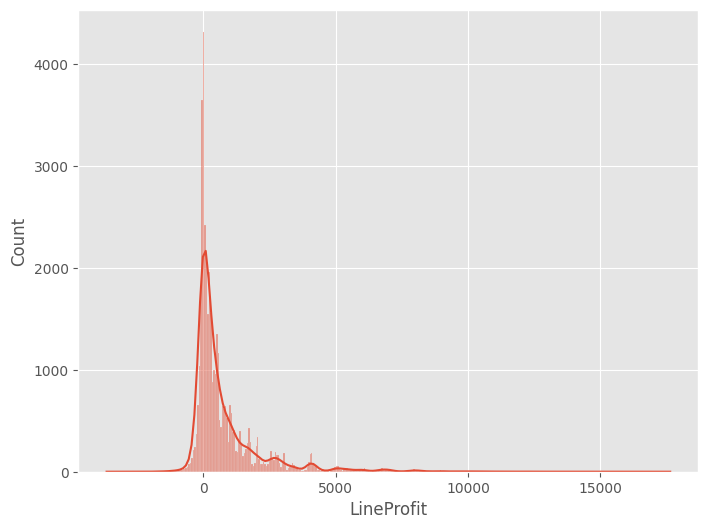

In [81]:
fig, axes = plt.subplots(figsize=(8, 6))
_ = sns.histplot(data=df_data, x="LineProfit", kde=True)
plt.show()


The LineProfit has a mean around 785 and meadian around 262 with positive as well as negative outliers. The negative value indicates a loss while a positive value denotes a profit.

In [82]:
df_profit_monthly = df_data.groupby("OrderDate").agg(
    {
        "LineProfit": "sum",
        "SalesOrderNumber": "nunique",
        "LineCost": "sum",
        "LineRevenue": "sum",
    }
)
# df_profit_monthly.columns=df_profit_monthly.columns.map('_'.join)
df_profit_monthly = df_profit_monthly.reset_index("OrderDate")
df_profit_monthly.rename(
    columns={
        "LineProfit": "LineProfitSum",
        "SalesOrderNumber": "TotalSalesOrders",
        "LineCost": "LineCostSum",
        "LineRevenue": "LineRevenueSum",
    },
    inplace=True,
)
df_profit_monthly["AvgProfitSO"] = (
    df_profit_monthly["LineProfitSum"] / df_profit_monthly["TotalSalesOrders"]
)
df_profit_monthly["3MonthRollAvg"] = (
    df_profit_monthly["LineProfitSum"].rolling(3).mean()
)
df_profit_monthly["3MonthRollSO"] = (
    df_profit_monthly["TotalSalesOrders"].rolling(3).mean()
)
df_profit_monthly["3MonthRollProfitSO"] = (
    df_profit_monthly["AvgProfitSO"].rolling(3).mean()
)
df_profit_monthly["3MonthRollCost"] = df_profit_monthly["LineCostSum"].rolling(3).mean()
df_profit_monthly["3MonthRollRevenue"] = (
    df_profit_monthly["LineRevenueSum"].rolling(3).mean()
)


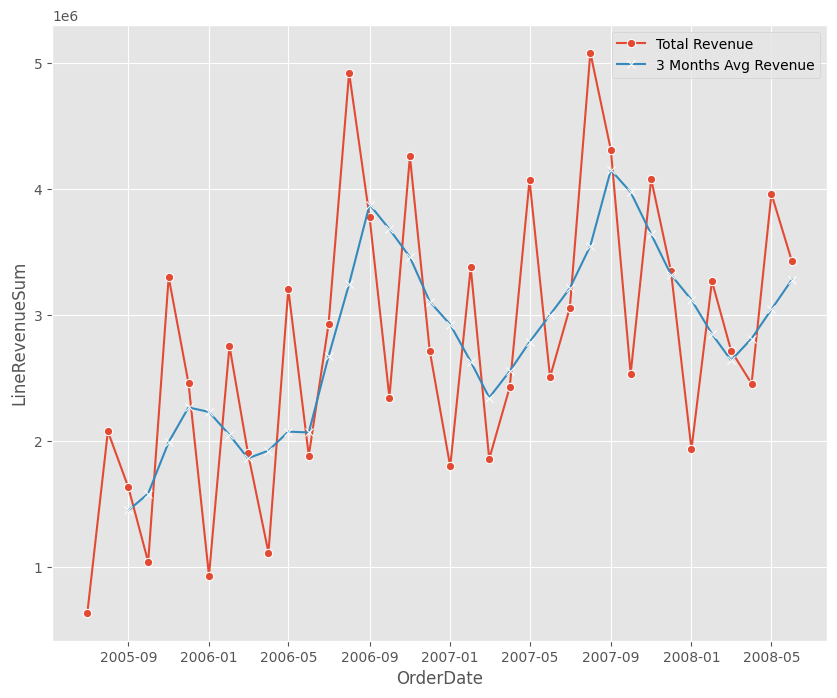

In [83]:
fig, ax = plt.subplots(figsize=(10, 8))
_ = sns.lineplot(
    data=df_profit_monthly,
    x="OrderDate",
    y="LineRevenueSum",
    marker="o",
    label="Total Revenue",
)
_ = sns.lineplot(
    data=df_profit_monthly,
    x="OrderDate",
    y="3MonthRollRevenue",
    marker="x",
    label="3 Months Avg Revenue",
)
plt.show()


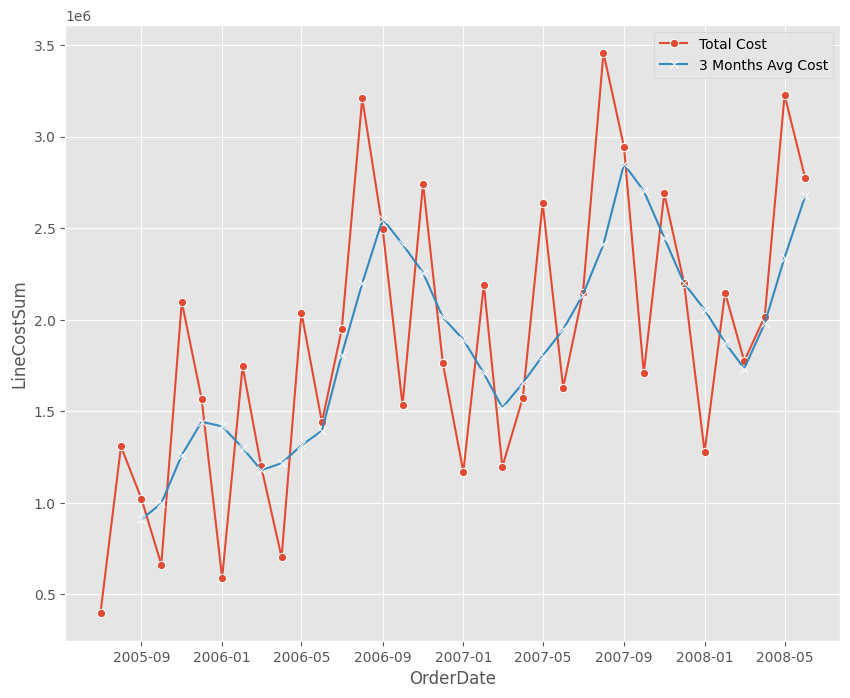

In [84]:
fig, ax = plt.subplots(figsize=(10, 8))
_ = sns.lineplot(
    data=df_profit_monthly,
    x="OrderDate",
    y="LineCostSum",
    marker="o",
    label="Total Cost",
)
_ = sns.lineplot(
    data=df_profit_monthly,
    x="OrderDate",
    y="3MonthRollCost",
    marker="x",
    label="3 Months Avg Cost",
)
plt.show()


The Total Cost follow same trends as Total Revenue with Gap between them getting closer in 2008

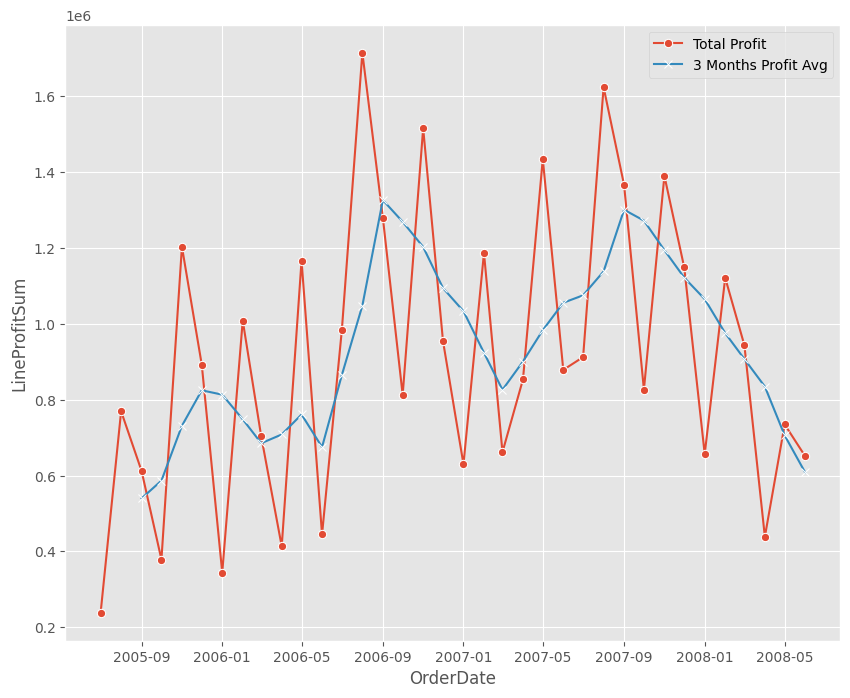

In [85]:
fig, ax = plt.subplots(figsize=(10, 8))
_ = sns.lineplot(
    data=df_profit_monthly,
    x="OrderDate",
    y="LineProfitSum",
    marker="o",
    label="Total Profit",
)
_ = sns.lineplot(
    data=df_profit_monthly,
    x="OrderDate",
    y="3MonthRollAvg",
    marker="x",
    label="3 Months Profit Avg",
)
plt.show()


Using 3 month moving average, we can confidentely say that the Profit is descreasing from September 2007 afterwards.

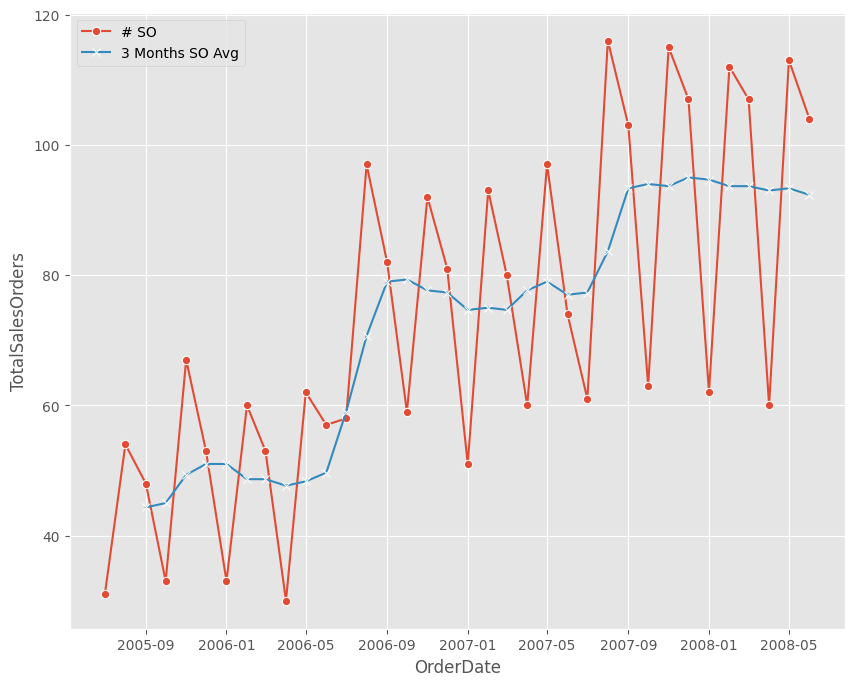

In [86]:
fig, ax = plt.subplots(figsize=(10, 8))
_ = sns.lineplot(
    data=df_profit_monthly,
    x="OrderDate",
    y="TotalSalesOrders",
    marker="o",
    label="# SO",
)
_ = sns.lineplot(
    data=df_profit_monthly,
    x="OrderDate",
    y="3MonthRollSO",
    marker="x",
    label="3 Months SO Avg",
)
plt.show()


Furthermore, we can see the number of SO are increasing over time. Again, considering the 3 month moving averaging, we see a stable number of SO from September 2007 onwards.

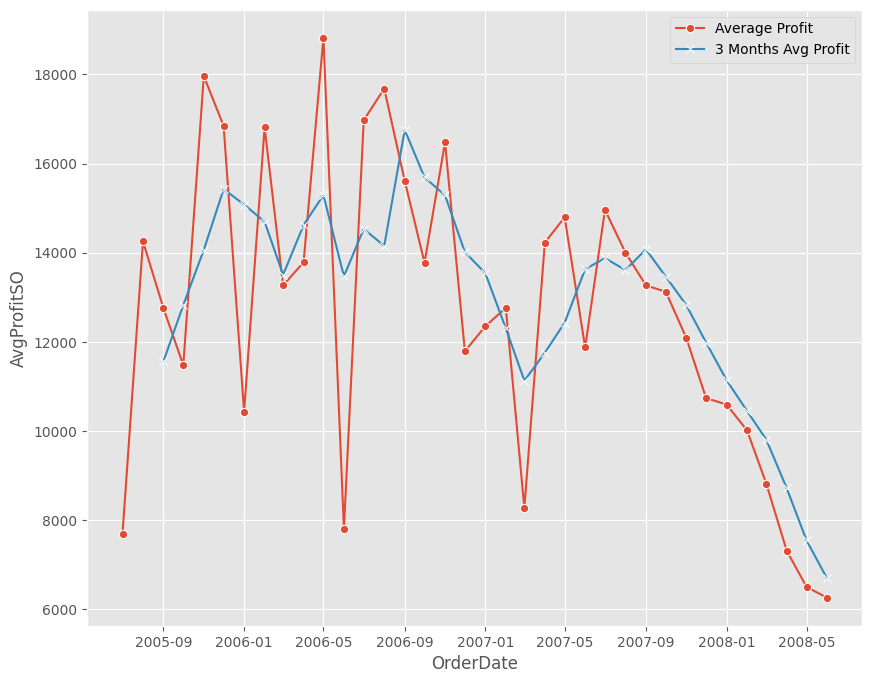

In [87]:
fig, ax = plt.subplots(figsize=(10, 8))
_ = sns.lineplot(
    data=df_profit_monthly,
    x="OrderDate",
    y="AvgProfitSO",
    marker="o",
    label="Average Profit",
)
_ = sns.lineplot(
    data=df_profit_monthly,
    x="OrderDate",
    y="3MonthRollProfitSO",
    marker="x",
    label="3 Months Avg Profit",
)
plt.show()


Average profit represents total monthly profit devied by total number of monthly SO. 

In [88]:
df_data_monthly = (
    df_data.groupby("OrderDate")
    .agg(
        {
            "SalesOrderNumber": "nunique",
            "LineItem_Id": "nunique",
            "LineProfit": "sum",
            "LineRevenue": "sum",
            "LineCost": "sum",
            "LineDiscount": "sum",
            "LineFreightCost": "sum",
            "Customer_Code": "nunique",
            "Sales_Person": "nunique",
            "OrderQty": "sum",
        }
    )
    .reset_index()
)

# Average Qty and LI over SO
df_data_monthly["LIPerSO"] = (
    df_data_monthly["LineItem_Id"] / df_data_monthly["SalesOrderNumber"]
)
df_data_monthly["QtyPerSO"] = (
    df_data_monthly["OrderQty"] / df_data_monthly["SalesOrderNumber"]
)

# Average over SO
df_data_monthly["AvgOrderValueSO"] = (
    df_data_monthly["LineRevenue"] / df_data_monthly["SalesOrderNumber"]
)
df_data_monthly["AvgCostSO"] = (
    df_data_monthly["LineCost"] / df_data_monthly["SalesOrderNumber"]
)
df_data_monthly["AvgProfitSO"] = (
    df_data_monthly["LineProfit"] / df_data_monthly["SalesOrderNumber"]
)
df_data_monthly["AvgFreightCostSO"] = (
    df_data_monthly["LineFreightCost"] / df_data_monthly["SalesOrderNumber"]
)

# Sales Order per Line Item
# df_data_monthly['AvgOrderCustomer'] = df_data_monthly['LineItem_Id'] / df_data_monthly['Customer_Code']
# df_data_monthly['AvgItemOrder'] = df_data_monthly['OrderQty'] / df_data_monthly['LineItem_Id']
# df_data_monthly['AvgOrderValue'] = df_data_monthly['LineRevenue'] / df_data_monthly['LineItem_Id']

df_data_monthly.head()


OrderDate  SalesOrderNumber  LineItem_Id    LineProfit   LineRevenue  \
0  2005-07-01                31          267  2.385128e+05  6.388715e+05   
1  2005-08-01                54          597  7.696477e+05  2.077746e+06   
2  2005-09-01                48          488  6.120439e+05  1.633579e+06   
3  2005-10-01                33          366  3.787511e+05  1.041946e+06   
4  2005-11-01                67          885  1.203396e+06  3.301063e+06   

       LineCost  LineDiscount  LineFreightCost  Customer_Code  Sales_Person  \
0  4.003587e+05          0.00       27240.5180             31             7   
1  1.308099e+06          4.43      113769.7028             54             8   
2  1.021535e+06          1.32       80640.1931             48             7   
3  6.631952e+05          1.85       52625.1070             33             7   
4  2.097667e+06          2.30      185718.0509             67             8   

   OrderQty    LIPerSO   QtyPerSO  AvgOrderValueSO     AvgCostSO  \
0       594   8.612903  19.161290     20608.759677  12914.798313   
1      1566  11.055556  29.000000     38476.784681  24224.050261   
2      1236  10.166667  25.750000     34032.901504  21281.986533   
3       875  11.090909  26.515152     31574.131364  20096.824882   
4      2352  13.208955  35.104478     49269.593537  31308.462690   

    AvgProfitSO  AvgFreightCostSO  
0   7693.961365        878.726387  
1  14252.734420       2106.846348  
2  12750.914971       1680.004023  
3  11477.306482       1594.700212  
4  17961.130848       2771.911207

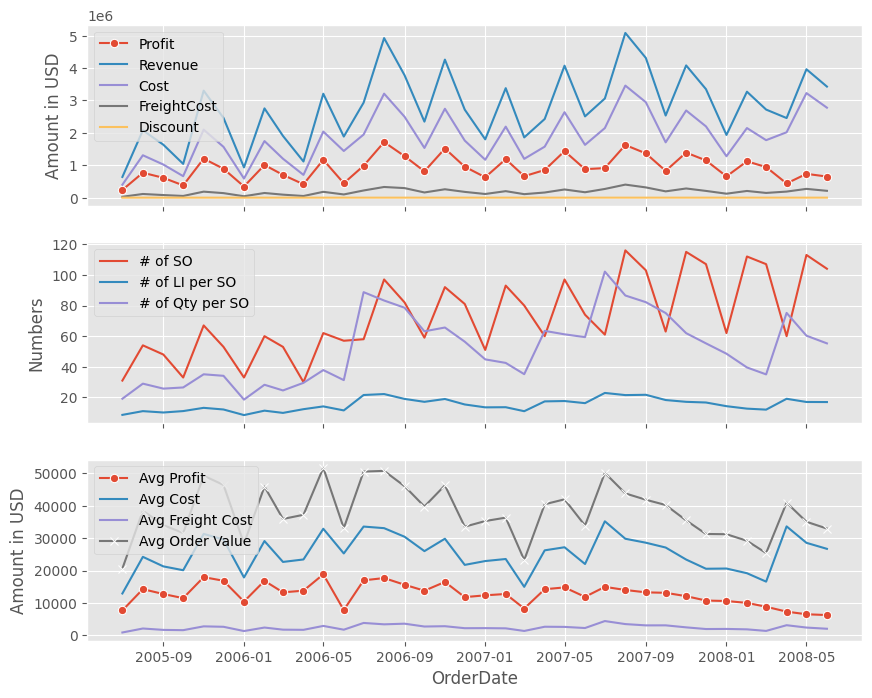

In [89]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))
_ = sns.lineplot(
    data=df_data_monthly,
    x="OrderDate",
    y="LineProfit",
    label="Profit",
    marker="o",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly, x="OrderDate", y="LineRevenue", label="Revenue", ax=ax1
)
_ = sns.lineplot(
    data=df_data_monthly, x="OrderDate", y="LineCost", label="Cost", ax=ax1
)
_ = sns.lineplot(
    data=df_data_monthly,
    x="OrderDate",
    y="LineFreightCost",
    label="FreightCost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly, x="OrderDate", y="LineDiscount", label="Discount", ax=ax1
)
ax1.set_ylabel("Amount in USD")
_ = sns.lineplot(
    data=df_data_monthly, x="OrderDate", y="SalesOrderNumber", label="# of SO", ax=ax2
)
_ = sns.lineplot(
    data=df_data_monthly, x="OrderDate", y="LIPerSO", label="# of LI per SO", ax=ax2
)
_ = sns.lineplot(
    data=df_data_monthly, x="OrderDate", y="QtyPerSO", label="# of Qty per SO", ax=ax2
)
ax2.set_ylabel("Numbers")
_ = sns.lineplot(
    data=df_data_monthly,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit",
    marker="o",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly, x="OrderDate", y="AvgCostSO", label="Avg Cost", ax=ax3
)
_ = sns.lineplot(
    data=df_data_monthly,
    x="OrderDate",
    y="AvgFreightCostSO",
    label="Avg Freight Cost",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly,
    x="OrderDate",
    y="AvgOrderValueSO",
    label="Avg Order Value",
    marker="x",
    ax=ax3,
)
ax3.set_ylabel("Amount in USD")
plt.show()


In [90]:
fig.savefig("./figures/ProfitDrop.png", format="png")


- The is no to very less variation in Discount. Thus, it has very minimal impact on the Average Profit per SO and Profit.
- The Cost follow Revenue with the gap between them getting closer as we approach the end of timeframe.
- The drop in profit is not gradual with some peaks.
- Profit per SO is gradually descraing from July 2007. It may due to increase in cost per order while Average Order Value (AOV) remains unchanged.

### Variation Across Sales Regions

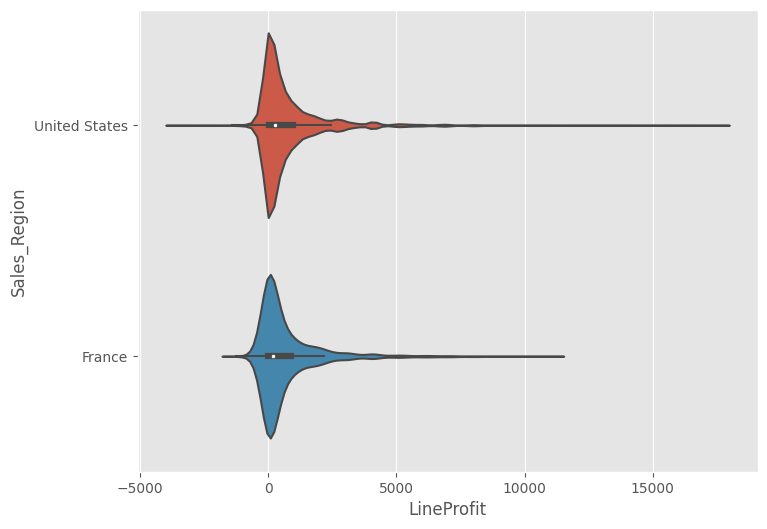

In [91]:
fig, axes = plt.subplots(figsize=(8, 6))
_ = sns.violinplot(data=df_data, x="LineProfit", y="Sales_Region")
plt.show()


In [92]:
df_data_monthly_region = (
    df_data.groupby(["OrderDate", "Sales_Region"])
    .agg(
        {
            "SalesOrderNumber": "nunique",
            "LineProfit": "sum",
            "LineRevenue": "sum",
            "LineCost": "sum",
            "LineItem_Id": "nunique",
            "LineDiscount": "sum",
            "OrderQty": "sum",
            "Customer_Code": "nunique",
            "Sales_Person": "nunique",
            "LineFreightCost": "sum",
        }
    )
    .reset_index()
)

# Average Qty, LI over SO
df_data_monthly_region["LIPerSO"] = (
    df_data_monthly_region["LineItem_Id"] / df_data_monthly_region["SalesOrderNumber"]
)
df_data_monthly_region["QtyPerSO"] = (
    df_data_monthly_region["OrderQty"] / df_data_monthly_region["SalesOrderNumber"]
)

# Average over Sales Order
df_data_monthly_region["AvgOrderValueSO"] = (
    df_data_monthly_region["LineRevenue"] / df_data_monthly_region["SalesOrderNumber"]
)
df_data_monthly_region["AvgCostSO"] = (
    df_data_monthly_region["LineCost"] / df_data_monthly_region["SalesOrderNumber"]
)
df_data_monthly_region["AvgProfitSO"] = (
    df_data_monthly_region["LineProfit"] / df_data_monthly_region["SalesOrderNumber"]
)
df_data_monthly_region["AvgFreightCostSO"] = (
    df_data_monthly_region["LineFreightCost"]
    / df_data_monthly_region["SalesOrderNumber"]
)

df_data_monthly_region.tail()


OrderDate   Sales_Region  SalesOrderNumber     LineProfit   LineRevenue  \
55  2008-04-01  United States                57  425262.889225  2.404941e+06   
56  2008-05-01         France                14  158076.140100  9.115132e+05   
57  2008-05-01  United States                99  576790.974325  3.049905e+06   
58  2008-06-01         France                 9   31555.639850  1.997172e+05   
59  2008-06-01  United States                95  619558.220175  3.227586e+06   

        LineCost  LineItem_Id  LineDiscount  OrderQty  Customer_Code  \
55  1.979679e+06         1095         41.39      4360             57   
56  7.534370e+05          361         14.88      1490             14   
57  2.473114e+06         1564         88.68      5325             99   
58  1.681615e+05          108          3.43       445              9   
59  2.608028e+06         1658         57.30      5305             95   

    Sales_Person  LineFreightCost    LIPerSO    QtyPerSO  AvgOrderValueSO  \
55             9      184707.9112  19.210526   76.491228     42191.956128   
56             1       73215.7449  25.785714  106.428571     65108.082714   
57             9      197964.1859  15.797980   53.787879     30807.117339   
58             1       15235.8518  12.000000   49.444444     22190.795989   
59             9      195780.2106  17.452632   55.842105     33974.592899   

       AvgCostSO   AvgProfitSO  AvgFreightCostSO  
55  34731.203686   7460.752443       3240.489670  
56  53816.929850  11291.152864       5229.696064  
57  24980.945882   5826.171458       1999.638241  
58  18684.613783   3506.182206       1692.872422  
59  27452.927423   6521.665476       2060.844322

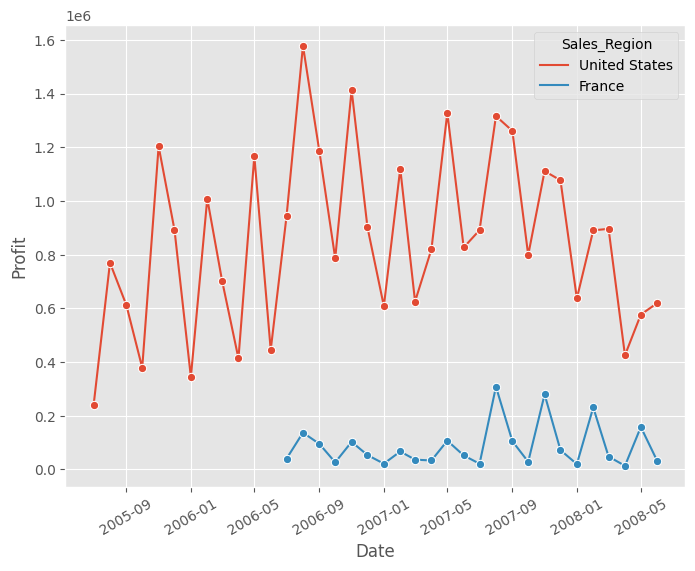

In [93]:
fig, axes = plt.subplots(figsize=(8, 6))
_ = sns.lineplot(
    data=df_data_monthly_region,
    x="OrderDate",
    y="LineProfit",
    hue="Sales_Region",
    marker="o",
)
plt.xticks(rotation=30)
axes.set_ylabel("Profit")
axes.set_xlabel("Date")
plt.show()


- It is evident from above that the United States is a major market for profit generation while France market is, introduced in June 2006, has less profit share.

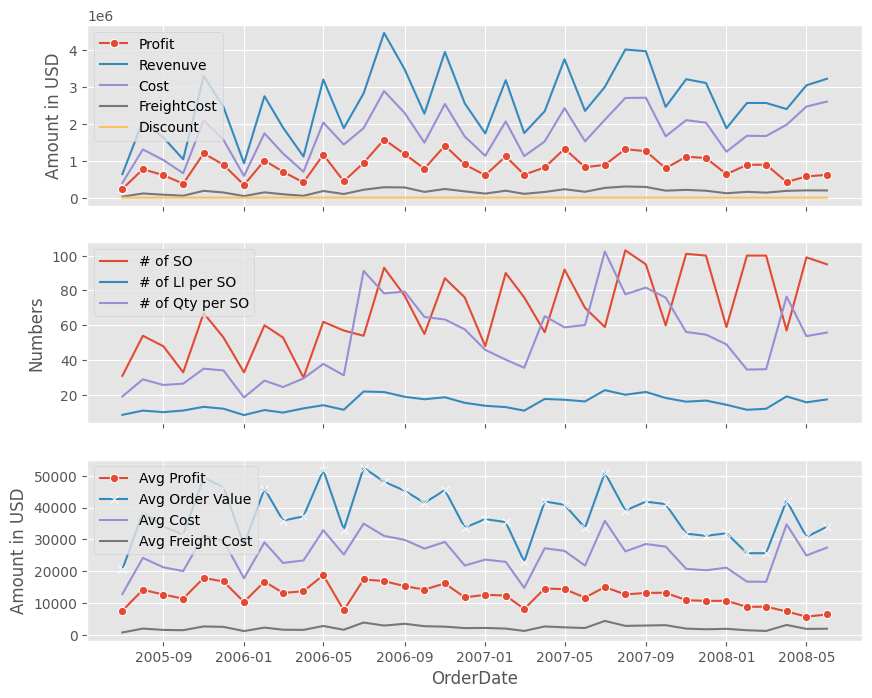

In [94]:
df_data_monthly_region_usa = df_data_monthly_region[
    df_data_monthly_region["Sales_Region"] == "United States"
]

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))
_ = sns.lineplot(
    data=df_data_monthly_region_usa,
    x="OrderDate",
    y="LineProfit",
    label="Profit",
    marker="o",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_region_usa,
    x="OrderDate",
    y="LineRevenue",
    label="Revenuve",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_region_usa, x="OrderDate", y="LineCost", label="Cost", ax=ax1
)
_ = sns.lineplot(
    data=df_data_monthly_region_usa,
    x="OrderDate",
    y="LineFreightCost",
    label="FreightCost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_region_usa,
    x="OrderDate",
    y="LineDiscount",
    label="Discount",
    ax=ax1,
)
ax1.set_ylabel("Amount in USD")
_ = sns.lineplot(
    data=df_data_monthly_region_usa,
    x="OrderDate",
    y="SalesOrderNumber",
    label="# of SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_region_usa,
    x="OrderDate",
    y="LIPerSO",
    label="# of LI per SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_region_usa,
    x="OrderDate",
    y="QtyPerSO",
    label="# of Qty per SO",
    ax=ax2,
)
ax2.set_ylabel("Numbers")
_ = sns.lineplot(
    data=df_data_monthly_region_usa,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit",
    marker="o",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_region_usa,
    x="OrderDate",
    y="AvgOrderValueSO",
    label="Avg Order Value",
    marker="x",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_region_usa,
    x="OrderDate",
    y="AvgCostSO",
    label="Avg Cost",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_region_usa,
    x="OrderDate",
    y="AvgFreightCostSO",
    label="Avg Freight Cost",
    ax=ax3,
)
ax3.set_ylabel("Amount in USD")
plt.show()


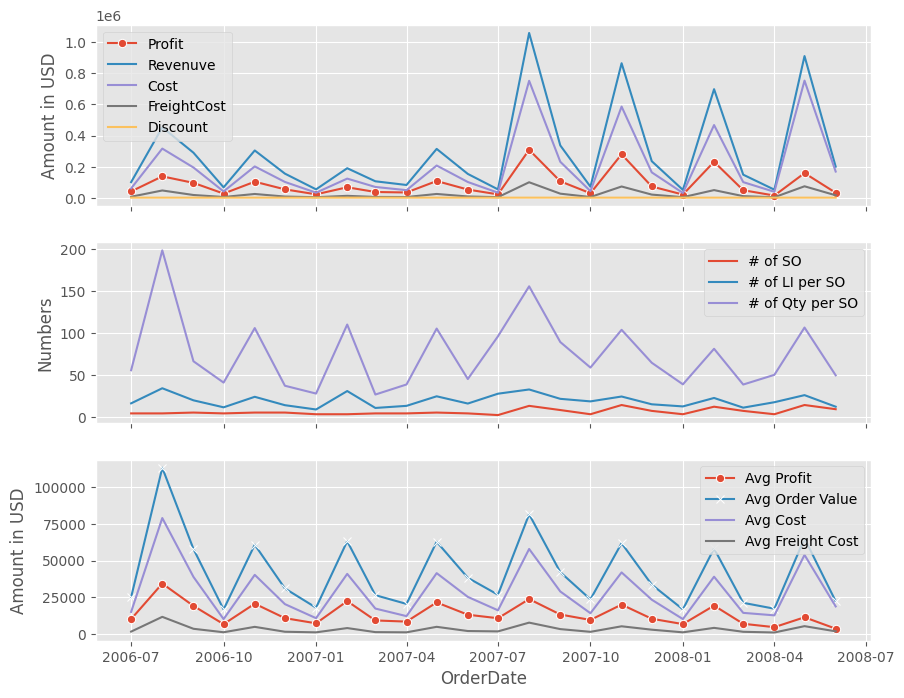

In [95]:
df_data_monthly_region_fr = df_data_monthly_region[
    df_data_monthly_region["Sales_Region"] == "France"
]


fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))
_ = sns.lineplot(
    data=df_data_monthly_region_fr,
    x="OrderDate",
    y="LineProfit",
    label="Profit",
    marker="o",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_region_fr,
    x="OrderDate",
    y="LineRevenue",
    label="Revenuve",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_region_fr, x="OrderDate", y="LineCost", label="Cost", ax=ax1
)
_ = sns.lineplot(
    data=df_data_monthly_region_fr,
    x="OrderDate",
    y="LineFreightCost",
    label="FreightCost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_region_fr,
    x="OrderDate",
    y="LineDiscount",
    label="Discount",
    ax=ax1,
)
ax1.set_ylabel("Amount in USD")
_ = sns.lineplot(
    data=df_data_monthly_region_fr,
    x="OrderDate",
    y="SalesOrderNumber",
    label="# of SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_region_fr,
    x="OrderDate",
    y="LIPerSO",
    label="# of LI per SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_region_fr,
    x="OrderDate",
    y="QtyPerSO",
    label="# of Qty per SO",
    ax=ax2,
)
ax2.set_ylabel("Numbers")
_ = sns.lineplot(
    data=df_data_monthly_region_fr,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit",
    marker="o",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_region_fr,
    x="OrderDate",
    y="AvgOrderValueSO",
    label="Avg Order Value",
    marker="x",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_region_fr,
    x="OrderDate",
    y="AvgCostSO",
    label="Avg Cost",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_region_fr,
    x="OrderDate",
    y="AvgFreightCostSO",
    label="Avg Freight Cost",
    ax=ax3,
)
ax3.set_ylabel("Amount in USD")
plt.show()


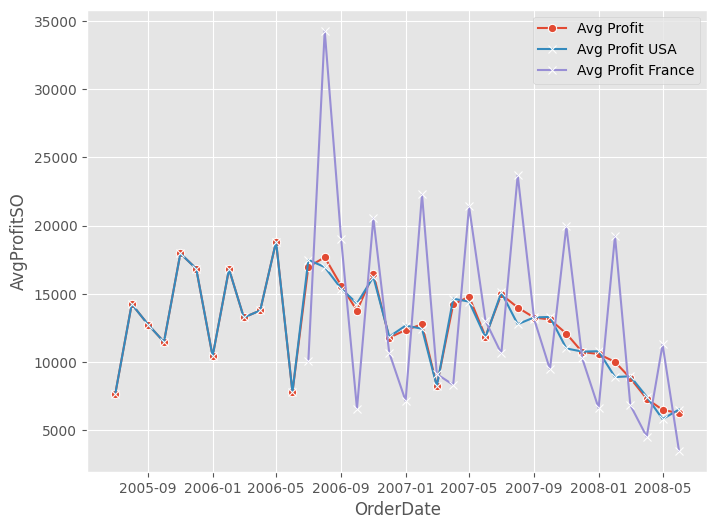

In [96]:
fig, axes = plt.subplots(figsize=(8, 6))
_ = sns.lineplot(
    data=df_data_monthly, x="OrderDate", y="AvgProfitSO", label="Avg Profit", marker="o"
)
_ = sns.lineplot(
    data=df_data_monthly_region_usa,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit USA",
    marker="x",
)
_ = sns.lineplot(
    data=df_data_monthly_region_fr,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit France",
    marker="x",
)
plt.show()


In [97]:
fig.savefig("./figures/SalesRegion.png", format="png")


- For US, Average Profit per SO is descreasing since Aug 2007 afterwards
- For France, Average Profit per SO is fluctuating

### Variations Across Product Categories

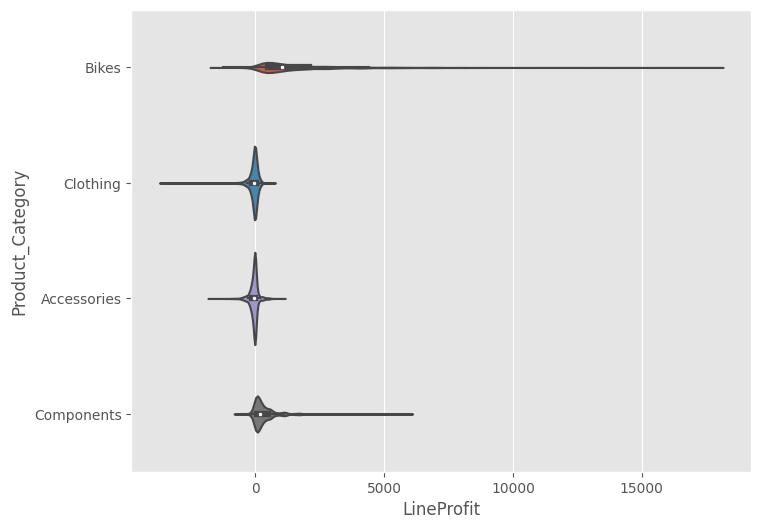

In [98]:
fig, axes = plt.subplots(figsize=(8, 6))
_ = sns.violinplot(data=df_data, x="LineProfit", y="Product_Category")
plt.show()


 - Bikes and Components product categories have more profit than loss
 - Clothing and Accessories product categories have more loss than profit

In [99]:
df_data_monthly_category = (
    df_data.groupby(["OrderDate", "Product_Category"])
    .agg(
        {
            "SalesOrderNumber": "nunique",
            "LineProfit": "sum",
            "LineRevenue": "sum",
            "LineCost": "sum",
            "LineItem_Id": "nunique",
            "LineDiscount": "sum",
            "OrderQty": "sum",
            "Customer_Code": "nunique",
            "Sales_Person": "nunique",
            "LineFreightCost": "sum",
        }
    )
    .reset_index()
)

# Average Qty, LI over SO
df_data_monthly_category["LIPerSO"] = (
    df_data_monthly_category["LineItem_Id"]
    / df_data_monthly_category["SalesOrderNumber"]
)
df_data_monthly_category["QtyPerSO"] = (
    df_data_monthly_category["OrderQty"] / df_data_monthly_category["SalesOrderNumber"]
)

# Average over Sales Order
df_data_monthly_category["AvgOrderValueSO"] = (
    df_data_monthly_category["LineRevenue"]
    / df_data_monthly_category["SalesOrderNumber"]
)
df_data_monthly_category["AvgCostSO"] = (
    df_data_monthly_category["LineCost"] / df_data_monthly_category["SalesOrderNumber"]
)
df_data_monthly_category["AvgProfitSO"] = (
    df_data_monthly_category["LineProfit"]
    / df_data_monthly_category["SalesOrderNumber"]
)
df_data_monthly_category["AvgFreightCostSO"] = (
    df_data_monthly_category["LineFreightCost"]
    / df_data_monthly_category["SalesOrderNumber"]
)

df_data_monthly_category.tail()


OrderDate Product_Category  SalesOrderNumber     LineProfit  \
139  2008-05-01       Components                89  126619.030850   
140  2008-06-01      Accessories                38   -6705.859350   
141  2008-06-01            Bikes                85  571435.143400   
142  2008-06-01         Clothing                68  -23479.384575   
143  2008-06-01       Components                86  109863.960550   

      LineRevenue      LineCost  LineItem_Id  LineDiscount  OrderQty  \
139  6.550566e+05  5.284376e+05          693          0.22      1796   
140  3.257557e+04  3.928143e+04          144          6.04       804   
141  2.756393e+06  2.184958e+06          681         42.36      1858   
142  7.044139e+04  9.392077e+04          295         12.33      1563   
143  5.678938e+05  4.580299e+05          646          0.00      1525   

     Customer_Code  Sales_Person  LineFreightCost   LIPerSO   QtyPerSO  \
139             89            10       71602.2460  7.786517  20.179775   
140             38            10       23935.6217  3.789474  21.157895   
141             85            10       82615.7092  8.011765  21.858824   
142             68            10       45560.3903  4.338235  22.985294   
143             86            10       58904.3412  7.511628  17.732558   

     AvgOrderValueSO     AvgCostSO  AvgProfitSO  AvgFreightCostSO  
139      7360.186445   5937.500705  1422.685740        804.519618  
140       857.251858   1033.721841  -176.469983        629.884782  
141     32428.149219  25705.382826  6722.766393        971.949520  
142      1035.902722   1381.187789  -345.285067        670.005740  
143      6603.416860   5325.928947  1277.487913        684.934200

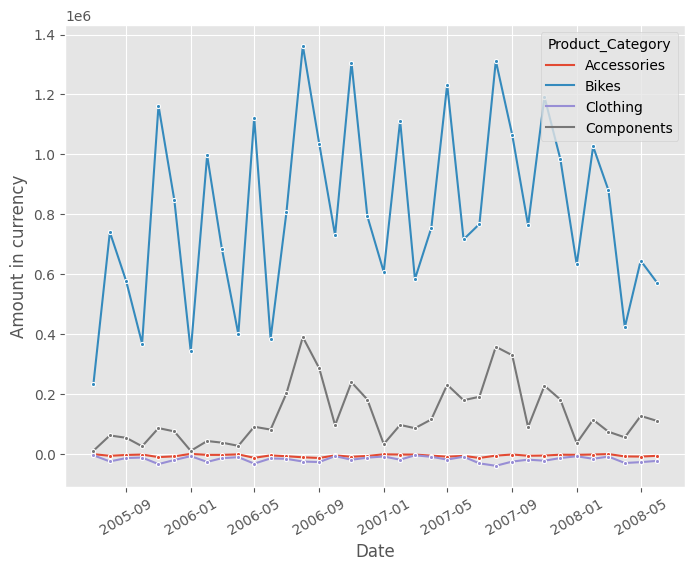

In [100]:
fig, axes = plt.subplots(figsize=(8, 6))
_ = sns.lineplot(
    data=df_data_monthly_category,
    x="OrderDate",
    y="LineProfit",
    hue="Product_Category",
    marker=".",
)
plt.xticks(rotation=30)
axes.set_ylabel("Amount in currency")
axes.set_xlabel("Date")
plt.show()


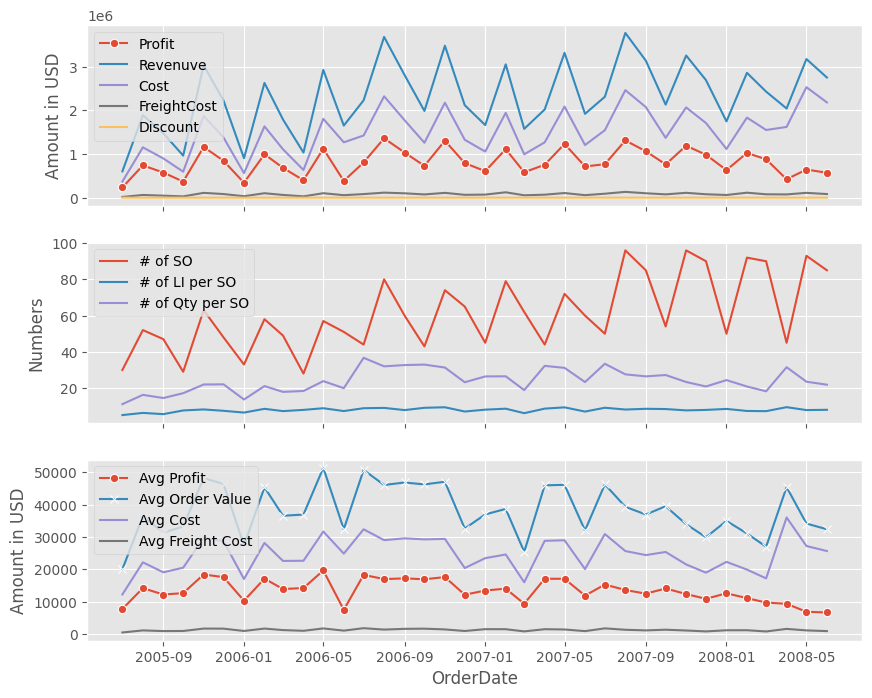

In [101]:
df_data_monthly_cat_bike = df_data_monthly_category[
    df_data_monthly_category["Product_Category"] == "Bikes"
]

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))
_ = sns.lineplot(
    data=df_data_monthly_cat_bike,
    x="OrderDate",
    y="LineProfit",
    label="Profit",
    marker="o",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_bike,
    x="OrderDate",
    y="LineRevenue",
    label="Revenuve",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_bike, x="OrderDate", y="LineCost", label="Cost", ax=ax1
)
_ = sns.lineplot(
    data=df_data_monthly_cat_bike,
    x="OrderDate",
    y="LineFreightCost",
    label="FreightCost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_bike,
    x="OrderDate",
    y="LineDiscount",
    label="Discount",
    ax=ax1,
)
ax1.set_ylabel("Amount in USD")
_ = sns.lineplot(
    data=df_data_monthly_cat_bike,
    x="OrderDate",
    y="SalesOrderNumber",
    label="# of SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_bike,
    x="OrderDate",
    y="LIPerSO",
    label="# of LI per SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_bike,
    x="OrderDate",
    y="QtyPerSO",
    label="# of Qty per SO",
    ax=ax2,
)
ax2.set_ylabel("Numbers")
_ = sns.lineplot(
    data=df_data_monthly_cat_bike,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit",
    marker="o",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_bike,
    x="OrderDate",
    y="AvgOrderValueSO",
    label="Avg Order Value",
    marker="x",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_bike,
    x="OrderDate",
    y="AvgCostSO",
    label="Avg Cost",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_bike,
    x="OrderDate",
    y="AvgFreightCostSO",
    label="Avg Freight Cost",
    ax=ax3,
)
ax3.set_ylabel("Amount in USD")
plt.show()


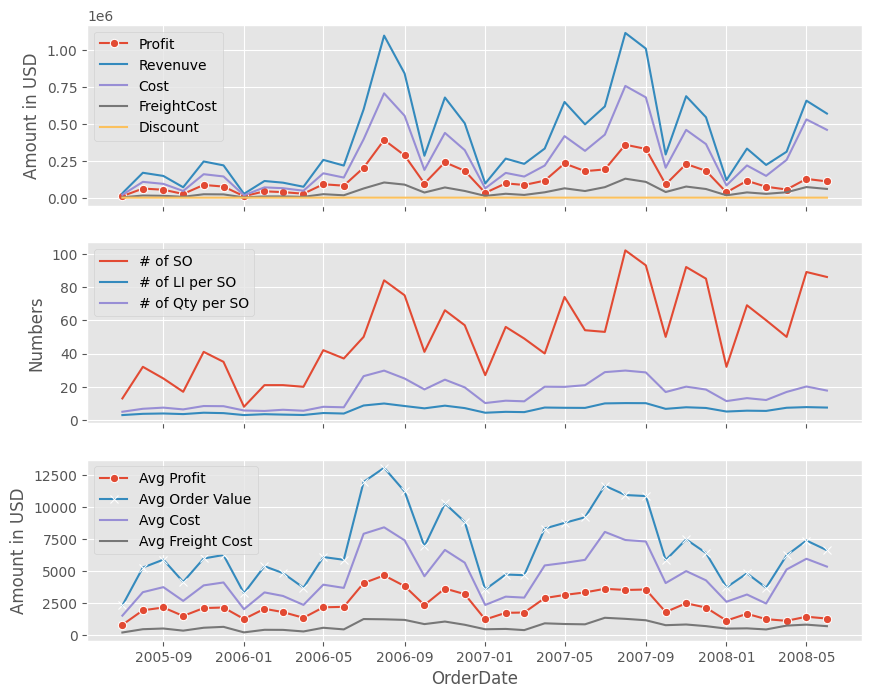

In [102]:
df_data_monthly_cat_comp = df_data_monthly_category[
    df_data_monthly_category["Product_Category"] == "Components"
]

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))
_ = sns.lineplot(
    data=df_data_monthly_cat_comp,
    x="OrderDate",
    y="LineProfit",
    label="Profit",
    marker="o",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_comp,
    x="OrderDate",
    y="LineRevenue",
    label="Revenuve",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_comp, x="OrderDate", y="LineCost", label="Cost", ax=ax1
)
_ = sns.lineplot(
    data=df_data_monthly_cat_comp,
    x="OrderDate",
    y="LineFreightCost",
    label="FreightCost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_comp,
    x="OrderDate",
    y="LineDiscount",
    label="Discount",
    ax=ax1,
)
ax1.set_ylabel("Amount in USD")
_ = sns.lineplot(
    data=df_data_monthly_cat_comp,
    x="OrderDate",
    y="SalesOrderNumber",
    label="# of SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_comp,
    x="OrderDate",
    y="LIPerSO",
    label="# of LI per SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_comp,
    x="OrderDate",
    y="QtyPerSO",
    label="# of Qty per SO",
    ax=ax2,
)
ax2.set_ylabel("Numbers")
_ = sns.lineplot(
    data=df_data_monthly_cat_comp,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit",
    marker="o",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_comp,
    x="OrderDate",
    y="AvgOrderValueSO",
    label="Avg Order Value",
    marker="x",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_comp,
    x="OrderDate",
    y="AvgCostSO",
    label="Avg Cost",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_comp,
    x="OrderDate",
    y="AvgFreightCostSO",
    label="Avg Freight Cost",
    ax=ax3,
)
ax3.set_ylabel("Amount in USD")
plt.show()


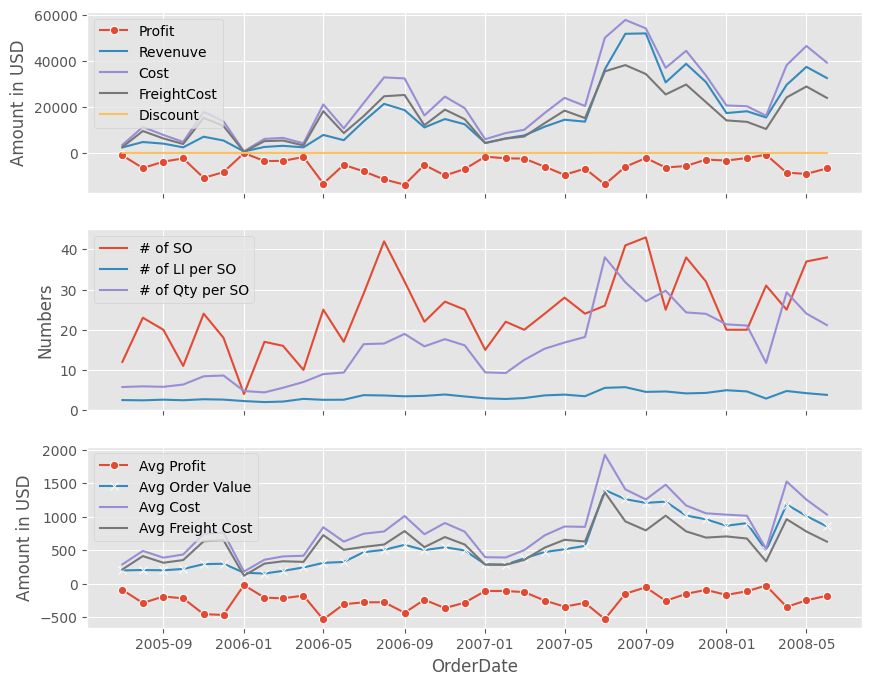

In [103]:
df_data_monthly_cat_access = df_data_monthly_category[
    df_data_monthly_category["Product_Category"] == "Accessories"
]

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))
_ = sns.lineplot(
    data=df_data_monthly_cat_access,
    x="OrderDate",
    y="LineProfit",
    label="Profit",
    marker="o",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_access,
    x="OrderDate",
    y="LineRevenue",
    label="Revenuve",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_access, x="OrderDate", y="LineCost", label="Cost", ax=ax1
)
_ = sns.lineplot(
    data=df_data_monthly_cat_access,
    x="OrderDate",
    y="LineFreightCost",
    label="FreightCost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_access,
    x="OrderDate",
    y="LineDiscount",
    label="Discount",
    ax=ax1,
)
ax1.set_ylabel("Amount in USD")
_ = sns.lineplot(
    data=df_data_monthly_cat_access,
    x="OrderDate",
    y="SalesOrderNumber",
    label="# of SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_access,
    x="OrderDate",
    y="LIPerSO",
    label="# of LI per SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_access,
    x="OrderDate",
    y="QtyPerSO",
    label="# of Qty per SO",
    ax=ax2,
)
ax2.set_ylabel("Numbers")
_ = sns.lineplot(
    data=df_data_monthly_cat_access,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit",
    marker="o",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_access,
    x="OrderDate",
    y="AvgOrderValueSO",
    label="Avg Order Value",
    marker="x",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_access,
    x="OrderDate",
    y="AvgCostSO",
    label="Avg Cost",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_access,
    x="OrderDate",
    y="AvgFreightCostSO",
    label="Avg Freight Cost",
    ax=ax3,
)
ax3.set_ylabel("Amount in USD")
plt.show()


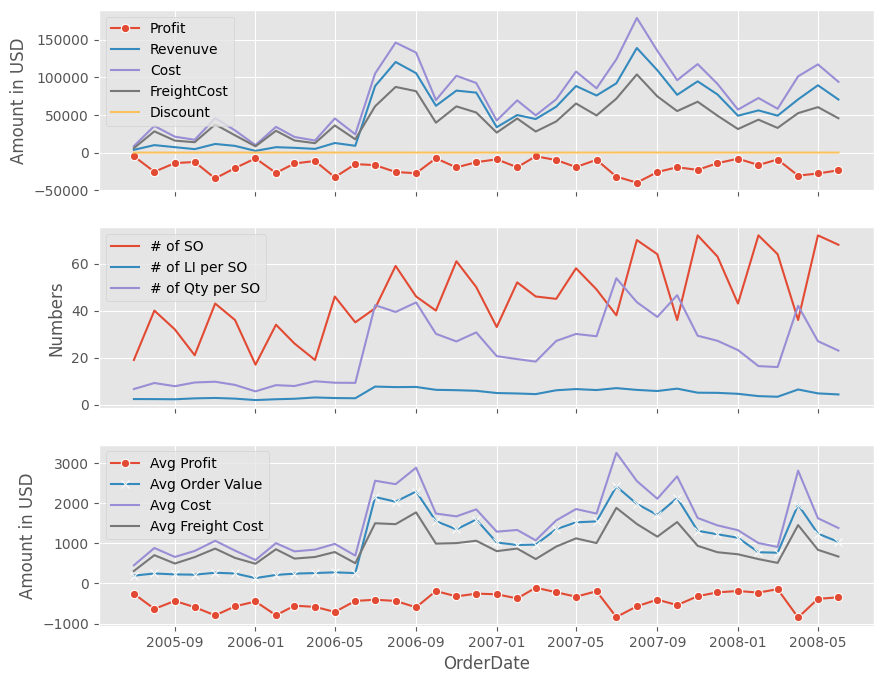

In [104]:
df_data_monthly_cat_cloth = df_data_monthly_category[
    df_data_monthly_category["Product_Category"] == "Clothing"
]

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))
_ = sns.lineplot(
    data=df_data_monthly_cat_cloth,
    x="OrderDate",
    y="LineProfit",
    label="Profit",
    marker="o",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_cloth,
    x="OrderDate",
    y="LineRevenue",
    label="Revenuve",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_cloth, x="OrderDate", y="LineCost", label="Cost", ax=ax1
)
_ = sns.lineplot(
    data=df_data_monthly_cat_cloth,
    x="OrderDate",
    y="LineFreightCost",
    label="FreightCost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_cloth,
    x="OrderDate",
    y="LineDiscount",
    label="Discount",
    ax=ax1,
)
ax1.set_ylabel("Amount in USD")
_ = sns.lineplot(
    data=df_data_monthly_cat_cloth,
    x="OrderDate",
    y="SalesOrderNumber",
    label="# of SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_cloth,
    x="OrderDate",
    y="LIPerSO",
    label="# of LI per SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_cloth,
    x="OrderDate",
    y="QtyPerSO",
    label="# of Qty per SO",
    ax=ax2,
)
ax2.set_ylabel("Numbers")
_ = sns.lineplot(
    data=df_data_monthly_cat_cloth,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit",
    marker="o",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_cloth,
    x="OrderDate",
    y="AvgOrderValueSO",
    label="Avg Order Value",
    marker="x",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_cloth,
    x="OrderDate",
    y="AvgCostSO",
    label="Avg Cost",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_cat_cloth,
    x="OrderDate",
    y="AvgFreightCostSO",
    label="Avg Freight Cost",
    ax=ax3,
)
ax3.set_ylabel("Amount in USD")
plt.show()


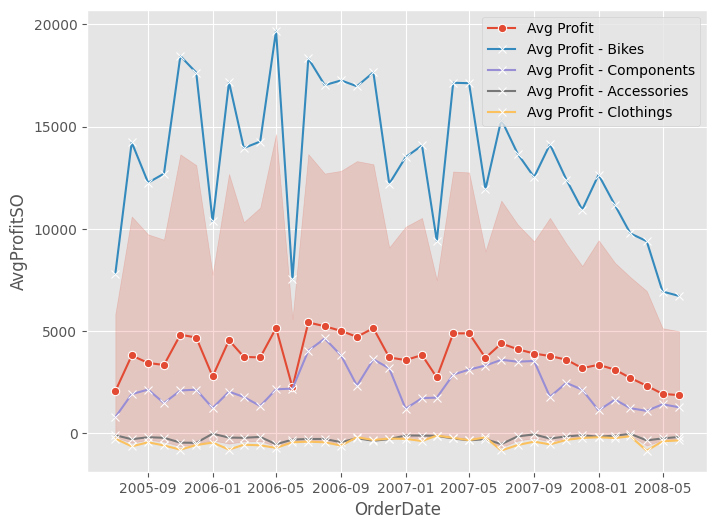

In [105]:
fig, axes = plt.subplots(figsize=(8, 6))
_ = sns.lineplot(
    data=df_data_monthly_category,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit",
    marker="o",
)
_ = sns.lineplot(
    data=df_data_monthly_cat_bike,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit - Bikes",
    marker="x",
)
_ = sns.lineplot(
    data=df_data_monthly_cat_comp,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit - Components",
    marker="x",
)
_ = sns.lineplot(
    data=df_data_monthly_cat_access,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit - Accessories",
    marker="x",
)
_ = sns.lineplot(
    data=df_data_monthly_cat_cloth,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit - Clothings",
    marker="x",
)
plt.show()


In [106]:
fig.savefig("./figures/ProductCategory.png", format="png")


- Bike product category has most impact on Average Profit per SO, followed by Components.
- There is a sharp decrease in Average Profit per SO for Bikes from Jan 2008 afterward.
- There is a gradual decrease in Average Profit per SO for Compoenets from August 2007 afterward.
- The Average Profit per SO is negative for Clothing and Accessories during the timeframe

### Variations Across Bike Sub-Categories

In [107]:
df_data_monthly_subcat = (
    df_data.groupby(["OrderDate", "Product_Category", "Product_Sub_Category"])
    .agg(
        {
            "SalesOrderNumber": "nunique",
            "LineProfit": "sum",
            "LineRevenue": "sum",
            "LineCost": "sum",
            "LineItem_Id": "nunique",
            "LineDiscount": "sum",
            "OrderQty": "sum",
            "Customer_Code": "nunique",
            "Sales_Person": "nunique",
            "LineFreightCost": "sum",
        }
    )
    .reset_index()
)

# Average Qty, LI over SO
df_data_monthly_subcat["LIPerSO"] = (
    df_data_monthly_subcat["LineItem_Id"] / df_data_monthly_subcat["SalesOrderNumber"]
)
df_data_monthly_subcat["QtyPerSO"] = (
    df_data_monthly_subcat["OrderQty"] / df_data_monthly_subcat["SalesOrderNumber"]
)

df_data_monthly_subcat.tail()


OrderDate Product_Category Product_Sub_Category  SalesOrderNumber  \
607  2008-06-01       Components      Mountain Frames                20   
608  2008-06-01       Components               Pedals                45   
609  2008-06-01       Components          Road Frames                21   
610  2008-06-01       Components              Saddles                33   
611  2008-06-01       Components       Touring Frames                22   

       LineProfit  LineRevenue       LineCost  LineItem_Id  LineDiscount  \
607  54992.474825    210758.57  155766.095175          154           0.0   
608  -2137.434300     14110.60   16248.034300           91           0.0   
609  21654.307100    130868.68  109214.372900           74           0.0   
610  -1956.170675      5024.34    6980.510675           49           0.0   
611  29196.609050    154540.09  125343.480950           88           0.0   

     OrderQty  Customer_Code  Sales_Person  LineFreightCost   LIPerSO  \
607       355             20             9       11501.8478  7.700000   
608       230             45            10        8416.6398  2.022222   
609       188             21             8        9950.4839  3.523810   
610       117             33            10        4191.9968  1.484848   
611       188             22             9        9554.3137  4.000000   

      QtyPerSO  
607  17.750000  
608   5.111111  
609   8.952381  
610   3.545455  
611   8.545455

In [108]:
df_data_monthly_cat_bike = df_data_monthly_subcat[
    df_data_monthly_subcat["Product_Category"] == "Bikes"
]

# Average over Sales Order
df_data_monthly_cat_bike["AvgOrderValueSO"] = (
    df_data_monthly_cat_bike["LineRevenue"]
    / df_data_monthly_cat_bike["SalesOrderNumber"]
)
df_data_monthly_cat_bike["AvgCostSO"] = (
    df_data_monthly_cat_bike["LineCost"] / df_data_monthly_cat_bike["SalesOrderNumber"]
)
df_data_monthly_cat_bike["AvgProfitSO"] = (
    df_data_monthly_cat_bike["LineProfit"]
    / df_data_monthly_cat_bike["SalesOrderNumber"]
)
df_data_monthly_cat_bike["AvgFreightCostSO"] = (
    df_data_monthly_cat_bike["LineFreightCost"]
    / df_data_monthly_cat_bike["SalesOrderNumber"]
)

df_data_monthly_cat_bike.tail()


/tmp/ipykernel_4737/547048705.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_monthly_cat_bike["AvgOrderValueSO"] = (
/tmp/ipykernel_4737/547048705.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_monthly_cat_bike["AvgCostSO"] = (
/tmp/ipykernel_4737/547048705.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

OrderDate Product_Category Product_Sub_Category  SalesOrderNumber  \
567  2008-05-01            Bikes           Road Bikes                37   
568  2008-05-01            Bikes        Touring Bikes                19   
592  2008-06-01            Bikes       Mountain Bikes                24   
593  2008-06-01            Bikes           Road Bikes                30   
594  2008-06-01            Bikes        Touring Bikes                31   

        LineProfit   LineRevenue      LineCost  LineItem_Id  LineDiscount  \
567  224164.910025  1.307668e+06  1.083504e+06          317          0.00   
568  142140.999600  8.086379e+05  6.664969e+05          179          0.68   
592  221275.992575  7.934368e+05  5.721608e+05          184         38.00   
593  143714.052350  8.955138e+05  7.517998e+05          209          4.36   
594  206445.098475  1.067442e+06  8.609970e+05          288          0.00   

     OrderQty  Customer_Code  Sales_Person  LineFreightCost   LIPerSO  \
567       905             37             9       43253.3256  8.567568   
568       547             19             8       37231.7471  9.421053   
592       506             24            10       16467.9678  7.666667   
593       658             30             7       34553.2755  6.966667   
594       694             31            10       31594.4659  9.290323   

      QtyPerSO  AvgOrderValueSO     AvgCostSO  AvgProfitSO  AvgFreightCostSO  
567  24.459459     35342.390000  29283.878918  6058.511082       1169.008800  
568  28.789474     42559.891326  35078.786084  7481.105242       1959.565637  
592  21.083333     33059.867500  23840.034476  9219.833024        686.165325  
593  21.933333     29850.460120  25059.991708  4790.468412       1151.775850  
594  22.387097     34433.614839  27774.095533  6659.519306       1019.176319

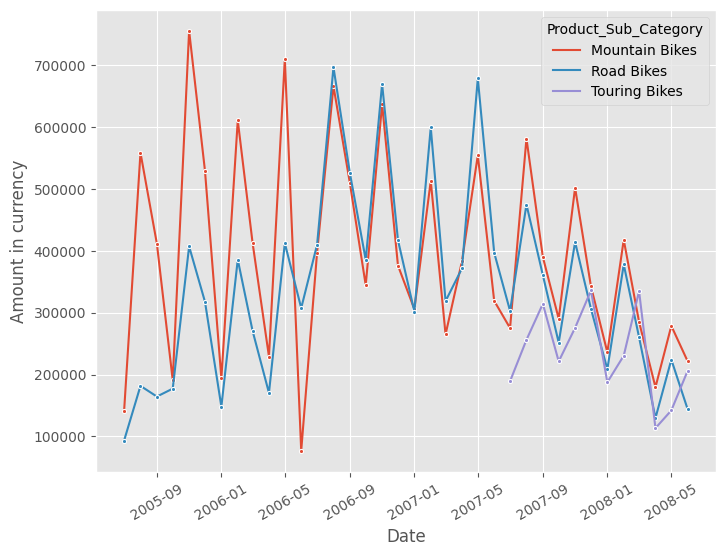

In [109]:
fig, axes = plt.subplots(figsize=(8, 6))
_ = sns.lineplot(
    data=df_data_monthly_cat_bike,
    x="OrderDate",
    y="LineProfit",
    hue="Product_Sub_Category",
    marker=".",
)
plt.xticks(rotation=30)
axes.set_ylabel("Amount in currency")
axes.set_xlabel("Date")
plt.show()


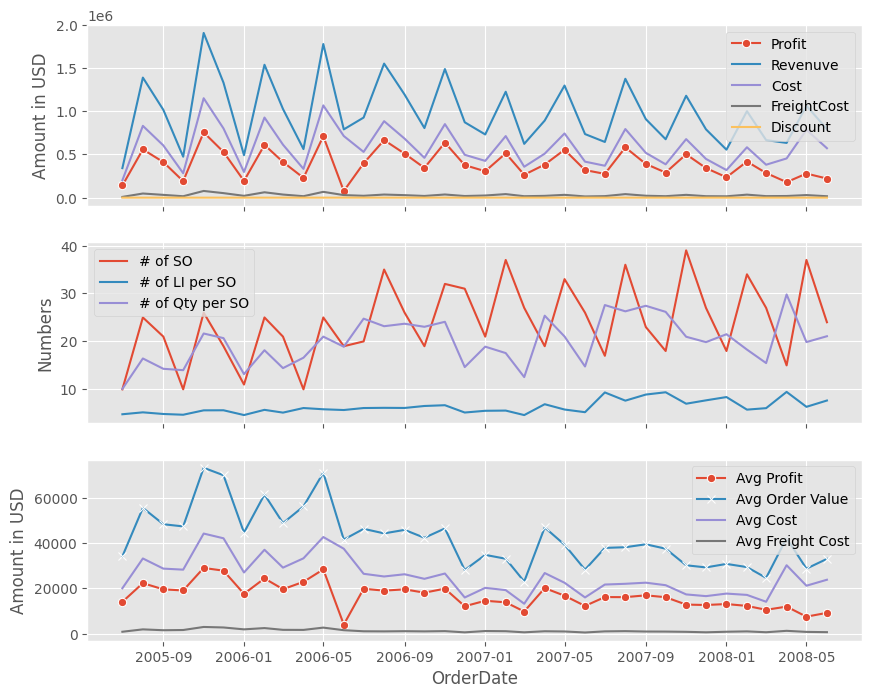

In [110]:
df_data_monthly_subcat_mb = df_data_monthly_cat_bike[
    df_data_monthly_cat_bike["Product_Sub_Category"] == "Mountain Bikes"
]

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))
_ = sns.lineplot(
    data=df_data_monthly_subcat_mb,
    x="OrderDate",
    y="LineProfit",
    label="Profit",
    marker="o",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_mb,
    x="OrderDate",
    y="LineRevenue",
    label="Revenuve",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_mb, x="OrderDate", y="LineCost", label="Cost", ax=ax1
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_mb,
    x="OrderDate",
    y="LineFreightCost",
    label="FreightCost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_mb,
    x="OrderDate",
    y="LineDiscount",
    label="Discount",
    ax=ax1,
)
ax1.set_ylabel("Amount in USD")
_ = sns.lineplot(
    data=df_data_monthly_subcat_mb,
    x="OrderDate",
    y="SalesOrderNumber",
    label="# of SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_mb,
    x="OrderDate",
    y="LIPerSO",
    label="# of LI per SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_mb,
    x="OrderDate",
    y="QtyPerSO",
    label="# of Qty per SO",
    ax=ax2,
)
ax2.set_ylabel("Numbers")
_ = sns.lineplot(
    data=df_data_monthly_subcat_mb,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit",
    marker="o",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_mb,
    x="OrderDate",
    y="AvgOrderValueSO",
    label="Avg Order Value",
    marker="x",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_mb,
    x="OrderDate",
    y="AvgCostSO",
    label="Avg Cost",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_mb,
    x="OrderDate",
    y="AvgFreightCostSO",
    label="Avg Freight Cost",
    ax=ax3,
)
ax3.set_ylabel("Amount in USD")
plt.show()


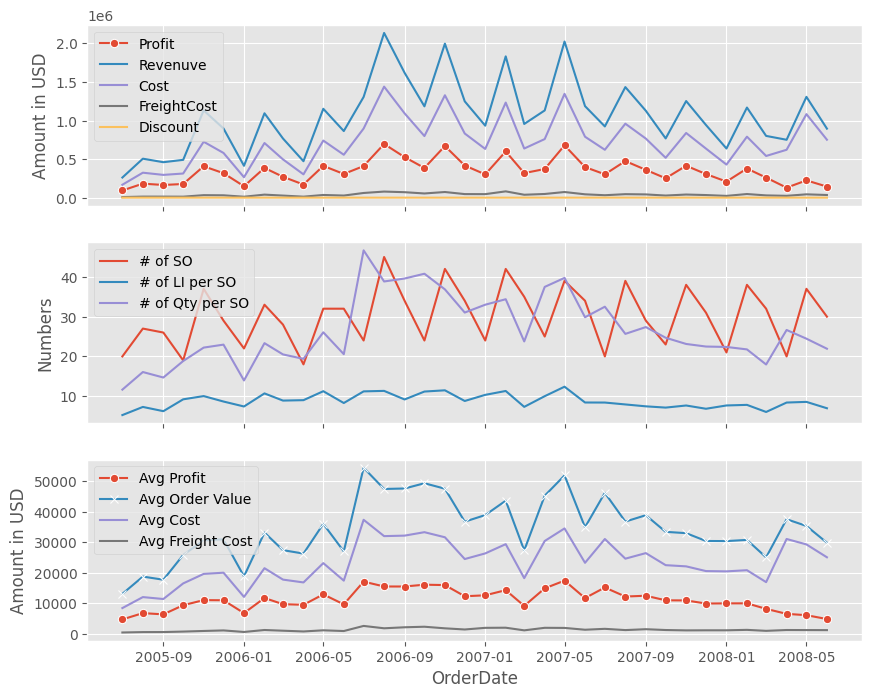

In [111]:
df_data_monthly_subcat_rb = df_data_monthly_cat_bike[
    df_data_monthly_cat_bike["Product_Sub_Category"] == "Road Bikes"
]

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))
_ = sns.lineplot(
    data=df_data_monthly_subcat_rb,
    x="OrderDate",
    y="LineProfit",
    label="Profit",
    marker="o",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_rb,
    x="OrderDate",
    y="LineRevenue",
    label="Revenuve",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_rb, x="OrderDate", y="LineCost", label="Cost", ax=ax1
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_rb,
    x="OrderDate",
    y="LineFreightCost",
    label="FreightCost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_rb,
    x="OrderDate",
    y="LineDiscount",
    label="Discount",
    ax=ax1,
)
ax1.set_ylabel("Amount in USD")
_ = sns.lineplot(
    data=df_data_monthly_subcat_rb,
    x="OrderDate",
    y="SalesOrderNumber",
    label="# of SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_rb,
    x="OrderDate",
    y="LIPerSO",
    label="# of LI per SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_rb,
    x="OrderDate",
    y="QtyPerSO",
    label="# of Qty per SO",
    ax=ax2,
)
ax2.set_ylabel("Numbers")
_ = sns.lineplot(
    data=df_data_monthly_subcat_rb,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit",
    marker="o",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_rb,
    x="OrderDate",
    y="AvgOrderValueSO",
    label="Avg Order Value",
    marker="x",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_rb,
    x="OrderDate",
    y="AvgCostSO",
    label="Avg Cost",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_rb,
    x="OrderDate",
    y="AvgFreightCostSO",
    label="Avg Freight Cost",
    ax=ax3,
)
ax3.set_ylabel("Amount in USD")
plt.show()


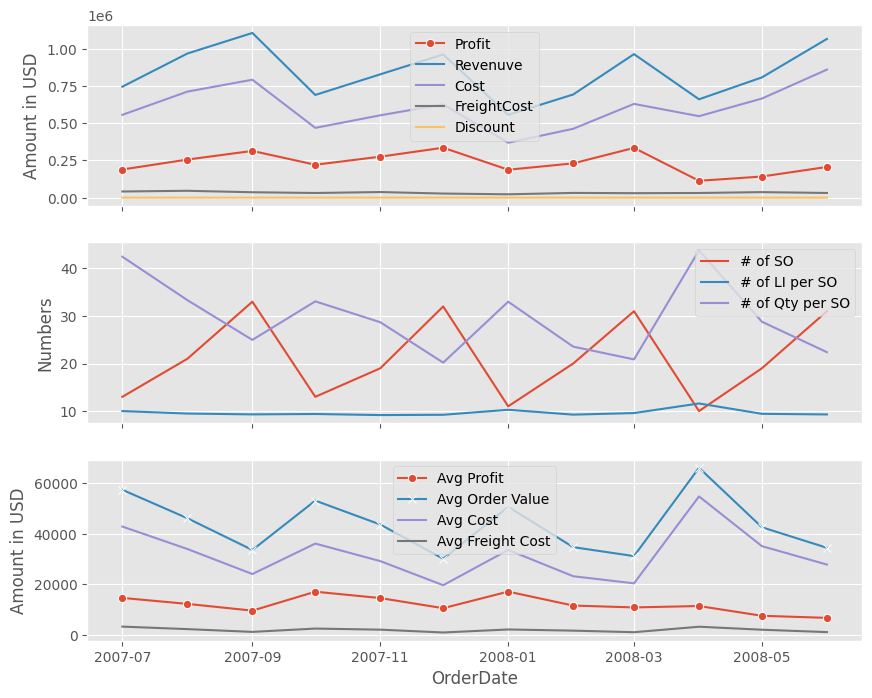

In [112]:
df_data_monthly_subcat_tb = df_data_monthly_cat_bike[
    df_data_monthly_cat_bike["Product_Sub_Category"] == "Touring Bikes"
]

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))
_ = sns.lineplot(
    data=df_data_monthly_subcat_tb,
    x="OrderDate",
    y="LineProfit",
    label="Profit",
    marker="o",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_tb,
    x="OrderDate",
    y="LineRevenue",
    label="Revenuve",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_tb, x="OrderDate", y="LineCost", label="Cost", ax=ax1
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_tb,
    x="OrderDate",
    y="LineFreightCost",
    label="FreightCost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_tb,
    x="OrderDate",
    y="LineDiscount",
    label="Discount",
    ax=ax1,
)
ax1.set_ylabel("Amount in USD")
_ = sns.lineplot(
    data=df_data_monthly_subcat_tb,
    x="OrderDate",
    y="SalesOrderNumber",
    label="# of SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_tb,
    x="OrderDate",
    y="LIPerSO",
    label="# of LI per SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_tb,
    x="OrderDate",
    y="QtyPerSO",
    label="# of Qty per SO",
    ax=ax2,
)
ax2.set_ylabel("Numbers")
_ = sns.lineplot(
    data=df_data_monthly_subcat_tb,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit",
    marker="o",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_tb,
    x="OrderDate",
    y="AvgOrderValueSO",
    label="Avg Order Value",
    marker="x",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_tb,
    x="OrderDate",
    y="AvgCostSO",
    label="Avg Cost",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_tb,
    x="OrderDate",
    y="AvgFreightCostSO",
    label="Avg Freight Cost",
    ax=ax3,
)
ax3.set_ylabel("Amount in USD")
plt.show()


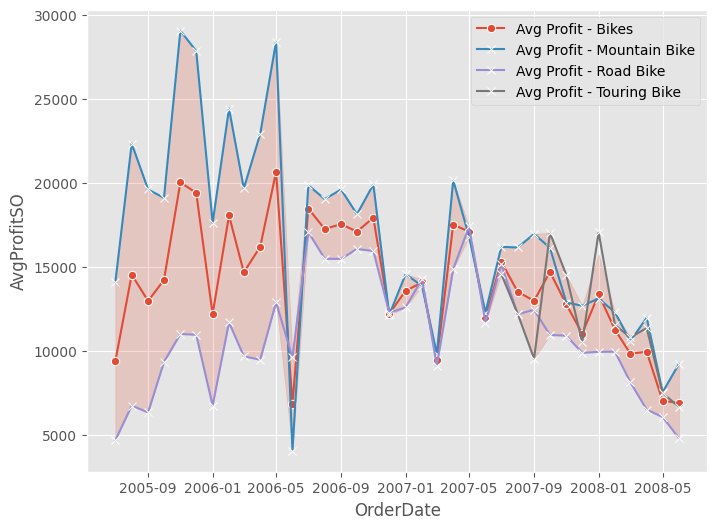

In [113]:
fig, axes = plt.subplots(figsize=(8, 6))
_ = sns.lineplot(
    data=df_data_monthly_cat_bike,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit - Bikes",
    marker="o",
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_mb,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit - Mountain Bike",
    marker="x",
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_rb,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit - Road Bike",
    marker="x",
)
_ = sns.lineplot(
    data=df_data_monthly_subcat_tb,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit - Touring Bike",
    marker="x",
)
plt.show()


In [114]:
fig.savefig("./figures/RoadBikes.png", format="png")


 - There is a gradual and contant dip in Average Profit per SO for Road Bikes
 - The Average Profit per SO for Touring and Mountain bike is also descreasing but with highs and lows
 - Touring Bike is introduced in July 2007

### Variations Across US Sales Province

In [115]:
df_data_monthly_province = (
    df_data.groupby(["OrderDate", "Sales_Region", "Sales_Province"])
    .agg(
        {
            "SalesOrderNumber": "nunique",
            "LineProfit": "sum",
            "LineRevenue": "sum",
            "LineCost": "sum",
            "LineItem_Id": "nunique",
            "LineDiscount": "sum",
            "OrderQty": "sum",
            "Customer_Code": "nunique",
            "Sales_Person": "nunique",
            "LineFreightCost": "sum",
        }
    )
    .reset_index()
)

# Average Qty, LI over SO
df_data_monthly_province["LIPerSO"] = (
    df_data_monthly_province["LineItem_Id"]
    / df_data_monthly_province["SalesOrderNumber"]
)
df_data_monthly_province["QtyPerSO"] = (
    df_data_monthly_province["OrderQty"] / df_data_monthly_province["SalesOrderNumber"]
)

# Average over Sales Order
df_data_monthly_province["AvgOrderValueSO"] = (
    df_data_monthly_province["LineRevenue"]
    / df_data_monthly_province["SalesOrderNumber"]
)
df_data_monthly_province["AvgCostSO"] = (
    df_data_monthly_province["LineCost"] / df_data_monthly_province["SalesOrderNumber"]
)
df_data_monthly_province["AvgProfitSO"] = (
    df_data_monthly_province["LineProfit"]
    / df_data_monthly_province["SalesOrderNumber"]
)
df_data_monthly_province["AvgFreightCostSO"] = (
    df_data_monthly_province["LineFreightCost"]
    / df_data_monthly_province["SalesOrderNumber"]
)

df_data_monthly_province.tail()


OrderDate   Sales_Region Sales_Province  SalesOrderNumber    LineProfit  \
288  2008-06-01  United States      Minnesota                14  87678.325875   
289  2008-06-01  United States         Oregon                 3  57429.579875   
290  2008-06-01  United States      Tennessee                13  64162.135450   
291  2008-06-01  United States           Utah                18  85055.236675   
292  2008-06-01  United States     Washington                 7  62102.271125   

     LineRevenue       LineCost  LineItem_Id  LineDiscount  OrderQty  \
288  566989.5127  479311.186825          296          9.87      1136   
289  256180.1086  198750.528725          119          7.86       373   
290  388266.5844  324104.448950          167          1.78       532   
291  482358.6708  397303.434125          264         13.33       915   
292  302279.4320  240177.160875          146          5.20       448   

     Customer_Code  Sales_Person  LineFreightCost    LIPerSO    QtyPerSO  \
288             14             1       42893.2267  21.142857   81.142857   
289              3             1       14939.6566  39.666667  124.333333   
290             13             1       25217.3067  12.846154   40.923077   
291             18             1       33388.9310  14.666667   50.833333   
292              7             2       16650.4180  20.857143   64.000000   

     AvgOrderValueSO     AvgCostSO   AvgProfitSO  AvgFreightCostSO  
288     40499.250907  34236.513345   6262.737562       3063.801907  
289     85393.369533  66250.176242  19143.193292       4979.885533  
290     29866.660338  24931.111458   4935.548881       1939.792823  
291     26797.703933  22072.413007   4725.290926       1854.940611  
292     43182.776000  34311.022982   8871.753018       2378.631143

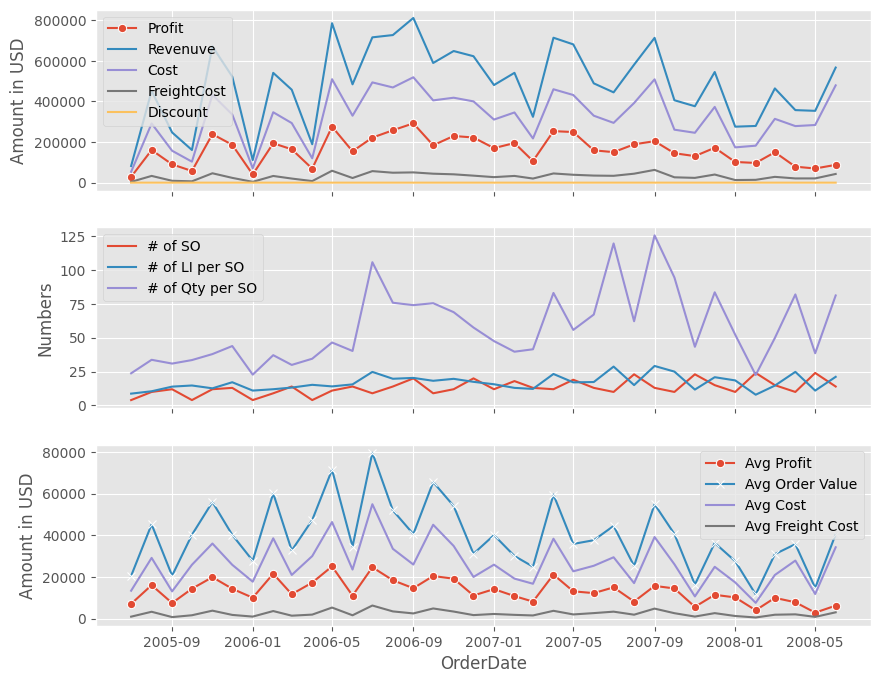

In [116]:
df_data_monthly_province_minn = df_data_monthly_province[
    df_data_monthly_province["Sales_Province"] == "Minnesota"
]

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))
_ = sns.lineplot(
    data=df_data_monthly_province_minn,
    x="OrderDate",
    y="LineProfit",
    label="Profit",
    marker="o",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_minn,
    x="OrderDate",
    y="LineRevenue",
    label="Revenuve",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_minn,
    x="OrderDate",
    y="LineCost",
    label="Cost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_minn,
    x="OrderDate",
    y="LineFreightCost",
    label="FreightCost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_minn,
    x="OrderDate",
    y="LineDiscount",
    label="Discount",
    ax=ax1,
)
ax1.set_ylabel("Amount in USD")
_ = sns.lineplot(
    data=df_data_monthly_province_minn,
    x="OrderDate",
    y="SalesOrderNumber",
    label="# of SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_province_minn,
    x="OrderDate",
    y="LIPerSO",
    label="# of LI per SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_province_minn,
    x="OrderDate",
    y="QtyPerSO",
    label="# of Qty per SO",
    ax=ax2,
)
ax2.set_ylabel("Numbers")
_ = sns.lineplot(
    data=df_data_monthly_province_minn,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit",
    marker="o",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_minn,
    x="OrderDate",
    y="AvgOrderValueSO",
    label="Avg Order Value",
    marker="x",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_minn,
    x="OrderDate",
    y="AvgCostSO",
    label="Avg Cost",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_minn,
    x="OrderDate",
    y="AvgFreightCostSO",
    label="Avg Freight Cost",
    ax=ax3,
)
ax3.set_ylabel("Amount in USD")
plt.show()


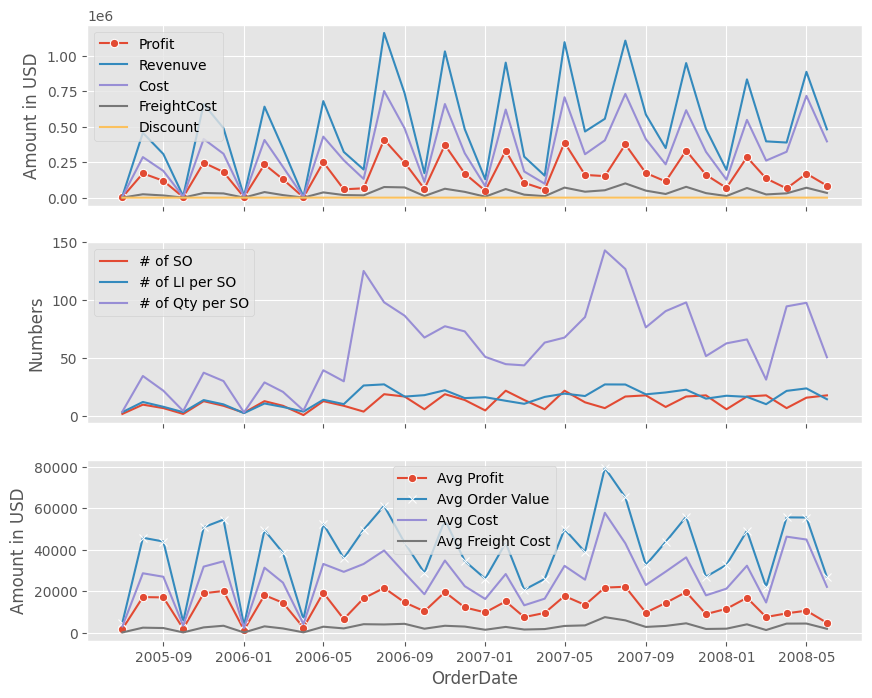

In [117]:
df_data_monthly_province_utah = df_data_monthly_province[
    df_data_monthly_province["Sales_Province"] == "Utah"
]

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))
_ = sns.lineplot(
    data=df_data_monthly_province_utah,
    x="OrderDate",
    y="LineProfit",
    label="Profit",
    marker="o",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_utah,
    x="OrderDate",
    y="LineRevenue",
    label="Revenuve",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_utah,
    x="OrderDate",
    y="LineCost",
    label="Cost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_utah,
    x="OrderDate",
    y="LineFreightCost",
    label="FreightCost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_utah,
    x="OrderDate",
    y="LineDiscount",
    label="Discount",
    ax=ax1,
)
ax1.set_ylabel("Amount in USD")
_ = sns.lineplot(
    data=df_data_monthly_province_utah,
    x="OrderDate",
    y="SalesOrderNumber",
    label="# of SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_province_utah,
    x="OrderDate",
    y="LIPerSO",
    label="# of LI per SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_province_utah,
    x="OrderDate",
    y="QtyPerSO",
    label="# of Qty per SO",
    ax=ax2,
)
ax2.set_ylabel("Numbers")
_ = sns.lineplot(
    data=df_data_monthly_province_utah,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit",
    marker="o",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_utah,
    x="OrderDate",
    y="AvgOrderValueSO",
    label="Avg Order Value",
    marker="x",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_utah,
    x="OrderDate",
    y="AvgCostSO",
    label="Avg Cost",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_utah,
    x="OrderDate",
    y="AvgFreightCostSO",
    label="Avg Freight Cost",
    ax=ax3,
)
ax3.set_ylabel("Amount in USD")
plt.show()


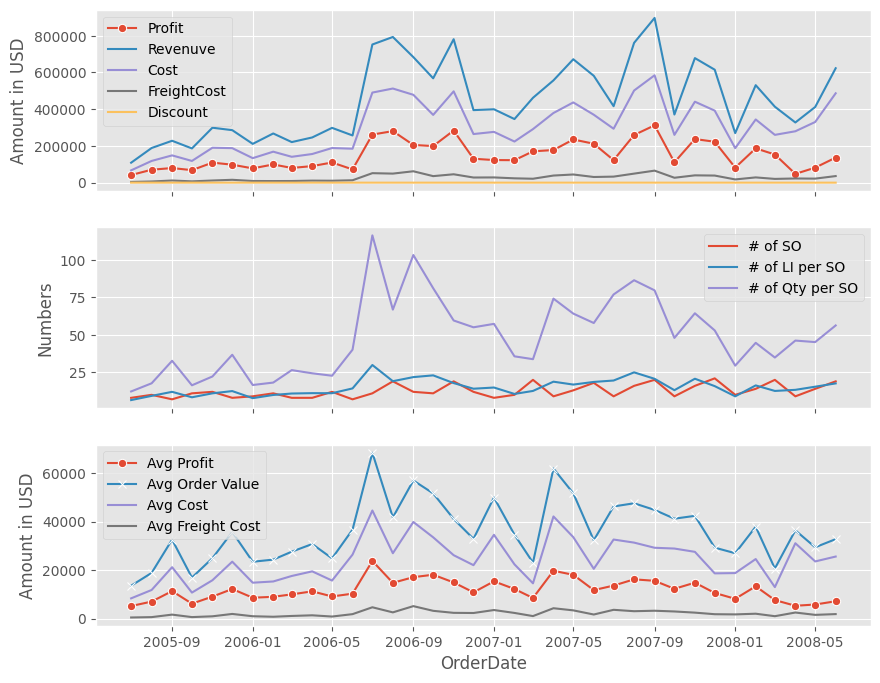

In [118]:
df_data_monthly_province_mich = df_data_monthly_province[
    df_data_monthly_province["Sales_Province"] == "Michigan"
]

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))
_ = sns.lineplot(
    data=df_data_monthly_province_mich,
    x="OrderDate",
    y="LineProfit",
    label="Profit",
    marker="o",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_mich,
    x="OrderDate",
    y="LineRevenue",
    label="Revenuve",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_mich,
    x="OrderDate",
    y="LineCost",
    label="Cost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_mich,
    x="OrderDate",
    y="LineFreightCost",
    label="FreightCost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_mich,
    x="OrderDate",
    y="LineDiscount",
    label="Discount",
    ax=ax1,
)
ax1.set_ylabel("Amount in USD")
_ = sns.lineplot(
    data=df_data_monthly_province_mich,
    x="OrderDate",
    y="SalesOrderNumber",
    label="# of SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_province_mich,
    x="OrderDate",
    y="LIPerSO",
    label="# of LI per SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_province_mich,
    x="OrderDate",
    y="QtyPerSO",
    label="# of Qty per SO",
    ax=ax2,
)
ax2.set_ylabel("Numbers")
_ = sns.lineplot(
    data=df_data_monthly_province_mich,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit",
    marker="o",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_mich,
    x="OrderDate",
    y="AvgOrderValueSO",
    label="Avg Order Value",
    marker="x",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_mich,
    x="OrderDate",
    y="AvgCostSO",
    label="Avg Cost",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_mich,
    x="OrderDate",
    y="AvgFreightCostSO",
    label="Avg Freight Cost",
    ax=ax3,
)
ax3.set_ylabel("Amount in USD")
plt.show()


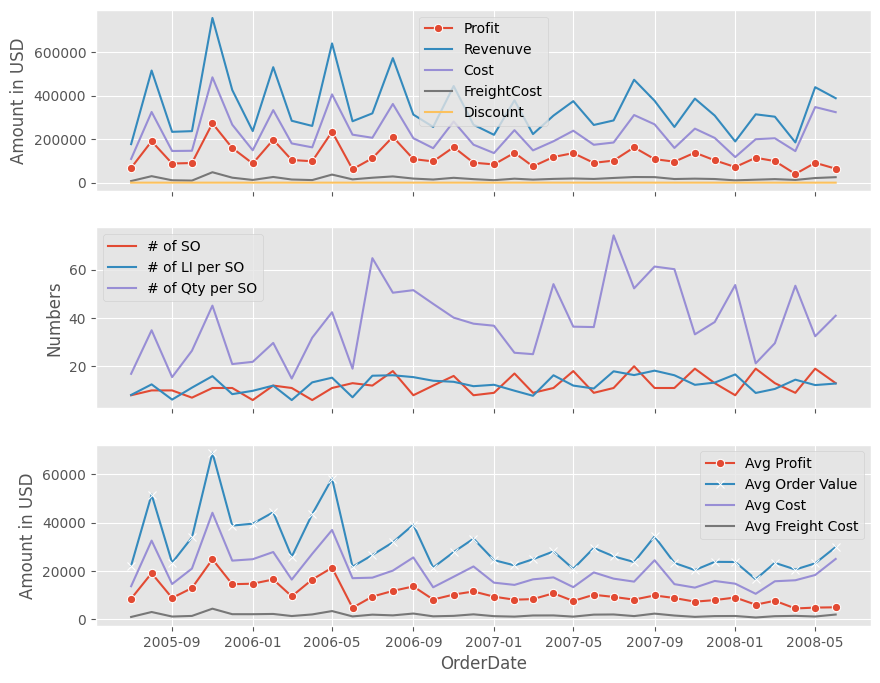

In [119]:
df_data_monthly_province_tenn = df_data_monthly_province[
    df_data_monthly_province["Sales_Province"] == "Tennessee"
]

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))
_ = sns.lineplot(
    data=df_data_monthly_province_tenn,
    x="OrderDate",
    y="LineProfit",
    label="Profit",
    marker="o",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_tenn,
    x="OrderDate",
    y="LineRevenue",
    label="Revenuve",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_tenn,
    x="OrderDate",
    y="LineCost",
    label="Cost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_tenn,
    x="OrderDate",
    y="LineFreightCost",
    label="FreightCost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_tenn,
    x="OrderDate",
    y="LineDiscount",
    label="Discount",
    ax=ax1,
)
ax1.set_ylabel("Amount in USD")
_ = sns.lineplot(
    data=df_data_monthly_province_tenn,
    x="OrderDate",
    y="SalesOrderNumber",
    label="# of SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_province_tenn,
    x="OrderDate",
    y="LIPerSO",
    label="# of LI per SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_province_tenn,
    x="OrderDate",
    y="QtyPerSO",
    label="# of Qty per SO",
    ax=ax2,
)
ax2.set_ylabel("Numbers")
_ = sns.lineplot(
    data=df_data_monthly_province_tenn,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit",
    marker="o",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_tenn,
    x="OrderDate",
    y="AvgOrderValueSO",
    label="Avg Order Value",
    marker="x",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_tenn,
    x="OrderDate",
    y="AvgCostSO",
    label="Avg Cost",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_tenn,
    x="OrderDate",
    y="AvgFreightCostSO",
    label="Avg Freight Cost",
    ax=ax3,
)
ax3.set_ylabel("Amount in USD")
plt.show()


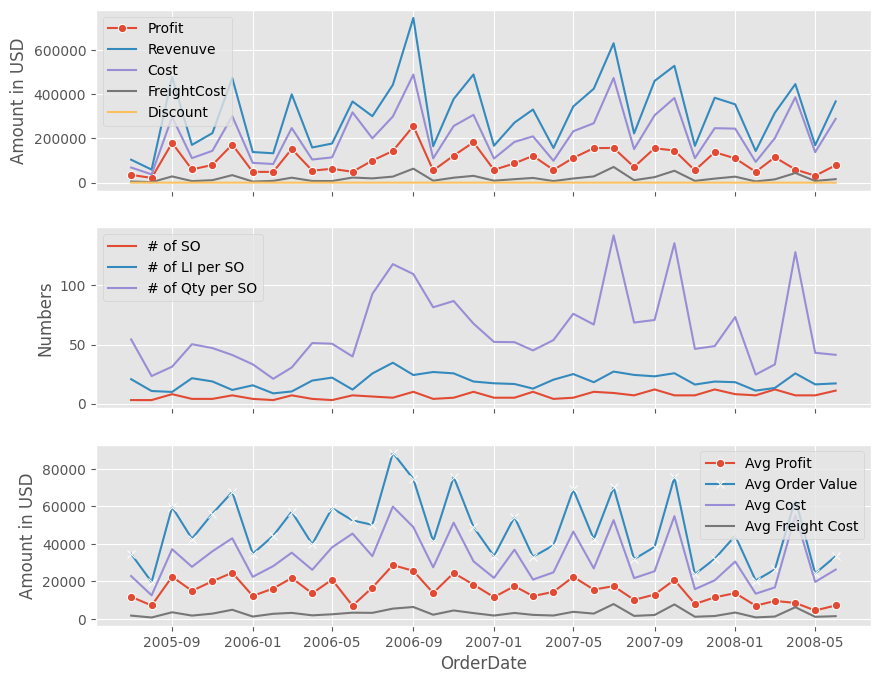

In [120]:
df_data_monthly_province_cali = df_data_monthly_province[
    df_data_monthly_province["Sales_Province"] == "California"
]

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))
_ = sns.lineplot(
    data=df_data_monthly_province_cali,
    x="OrderDate",
    y="LineProfit",
    label="Profit",
    marker="o",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_cali,
    x="OrderDate",
    y="LineRevenue",
    label="Revenuve",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_cali,
    x="OrderDate",
    y="LineCost",
    label="Cost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_cali,
    x="OrderDate",
    y="LineFreightCost",
    label="FreightCost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_cali,
    x="OrderDate",
    y="LineDiscount",
    label="Discount",
    ax=ax1,
)
ax1.set_ylabel("Amount in USD")
_ = sns.lineplot(
    data=df_data_monthly_province_cali,
    x="OrderDate",
    y="SalesOrderNumber",
    label="# of SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_province_cali,
    x="OrderDate",
    y="LIPerSO",
    label="# of LI per SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_province_cali,
    x="OrderDate",
    y="QtyPerSO",
    label="# of Qty per SO",
    ax=ax2,
)
ax2.set_ylabel("Numbers")
_ = sns.lineplot(
    data=df_data_monthly_province_cali,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit",
    marker="o",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_cali,
    x="OrderDate",
    y="AvgOrderValueSO",
    label="Avg Order Value",
    marker="x",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_cali,
    x="OrderDate",
    y="AvgCostSO",
    label="Avg Cost",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_cali,
    x="OrderDate",
    y="AvgFreightCostSO",
    label="Avg Freight Cost",
    ax=ax3,
)
ax3.set_ylabel("Amount in USD")
plt.show()


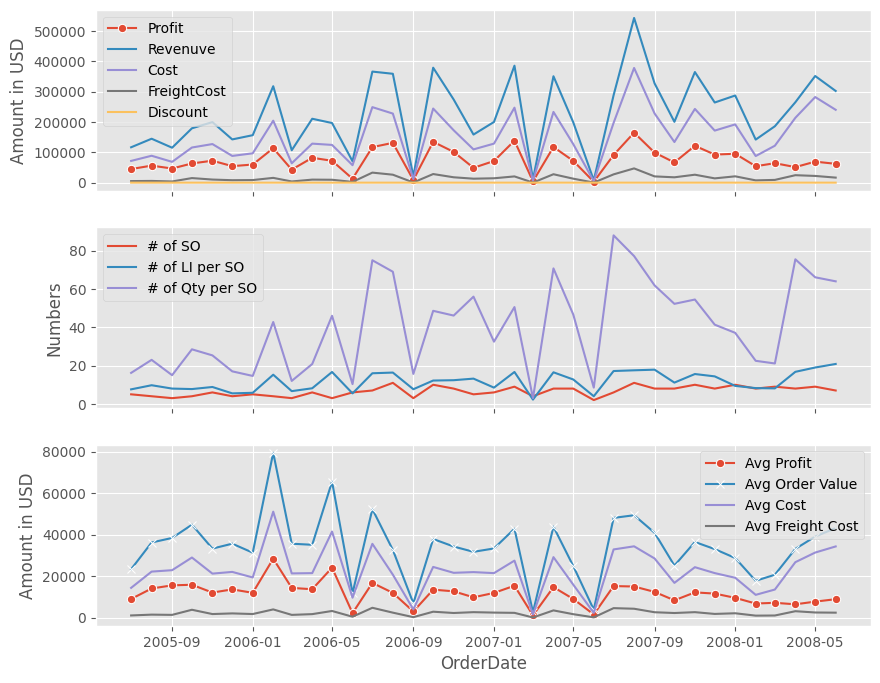

In [121]:
df_data_monthly_province_wash = df_data_monthly_province[
    df_data_monthly_province["Sales_Province"] == "Washington"
]

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))
_ = sns.lineplot(
    data=df_data_monthly_province_wash,
    x="OrderDate",
    y="LineProfit",
    label="Profit",
    marker="o",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_wash,
    x="OrderDate",
    y="LineRevenue",
    label="Revenuve",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_wash,
    x="OrderDate",
    y="LineCost",
    label="Cost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_wash,
    x="OrderDate",
    y="LineFreightCost",
    label="FreightCost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_wash,
    x="OrderDate",
    y="LineDiscount",
    label="Discount",
    ax=ax1,
)
ax1.set_ylabel("Amount in USD")
_ = sns.lineplot(
    data=df_data_monthly_province_wash,
    x="OrderDate",
    y="SalesOrderNumber",
    label="# of SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_province_wash,
    x="OrderDate",
    y="LIPerSO",
    label="# of LI per SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_province_wash,
    x="OrderDate",
    y="QtyPerSO",
    label="# of Qty per SO",
    ax=ax2,
)
ax2.set_ylabel("Numbers")
_ = sns.lineplot(
    data=df_data_monthly_province_wash,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit",
    marker="o",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_wash,
    x="OrderDate",
    y="AvgOrderValueSO",
    label="Avg Order Value",
    marker="x",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_wash,
    x="OrderDate",
    y="AvgCostSO",
    label="Avg Cost",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_wash,
    x="OrderDate",
    y="AvgFreightCostSO",
    label="Avg Freight Cost",
    ax=ax3,
)
ax3.set_ylabel("Amount in USD")
plt.show()


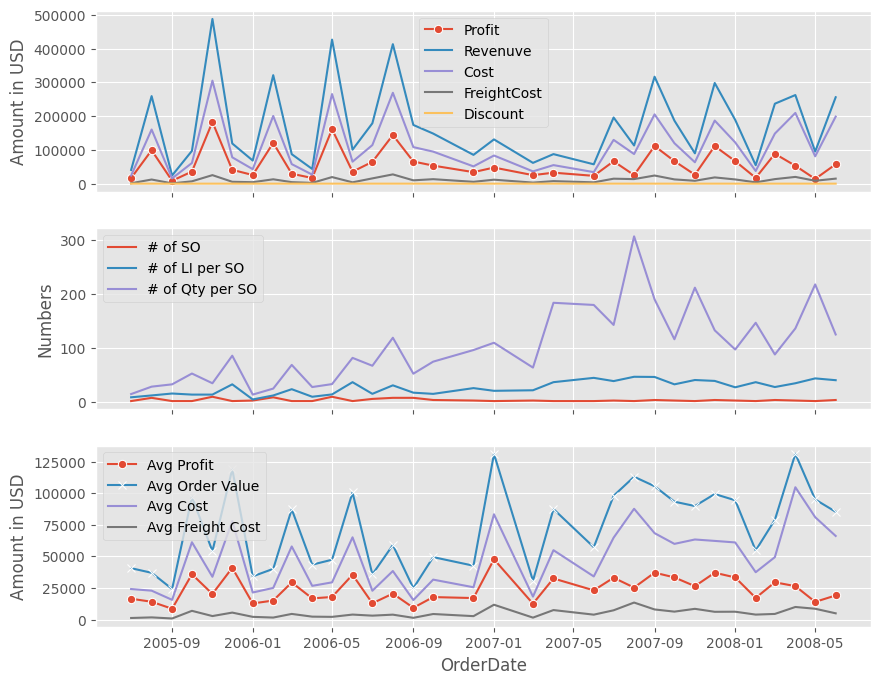

In [122]:
df_data_monthly_province_oreg = df_data_monthly_province[
    df_data_monthly_province["Sales_Province"] == "Oregon"
]

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))
_ = sns.lineplot(
    data=df_data_monthly_province_oreg,
    x="OrderDate",
    y="LineProfit",
    label="Profit",
    marker="o",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_oreg,
    x="OrderDate",
    y="LineRevenue",
    label="Revenuve",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_oreg,
    x="OrderDate",
    y="LineCost",
    label="Cost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_oreg,
    x="OrderDate",
    y="LineFreightCost",
    label="FreightCost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_oreg,
    x="OrderDate",
    y="LineDiscount",
    label="Discount",
    ax=ax1,
)
ax1.set_ylabel("Amount in USD")
_ = sns.lineplot(
    data=df_data_monthly_province_oreg,
    x="OrderDate",
    y="SalesOrderNumber",
    label="# of SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_province_oreg,
    x="OrderDate",
    y="LIPerSO",
    label="# of LI per SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_province_oreg,
    x="OrderDate",
    y="QtyPerSO",
    label="# of Qty per SO",
    ax=ax2,
)
ax2.set_ylabel("Numbers")
_ = sns.lineplot(
    data=df_data_monthly_province_oreg,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit",
    marker="o",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_oreg,
    x="OrderDate",
    y="AvgOrderValueSO",
    label="Avg Order Value",
    marker="x",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_oreg,
    x="OrderDate",
    y="AvgCostSO",
    label="Avg Cost",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_oreg,
    x="OrderDate",
    y="AvgFreightCostSO",
    label="Avg Freight Cost",
    ax=ax3,
)
ax3.set_ylabel("Amount in USD")
plt.show()


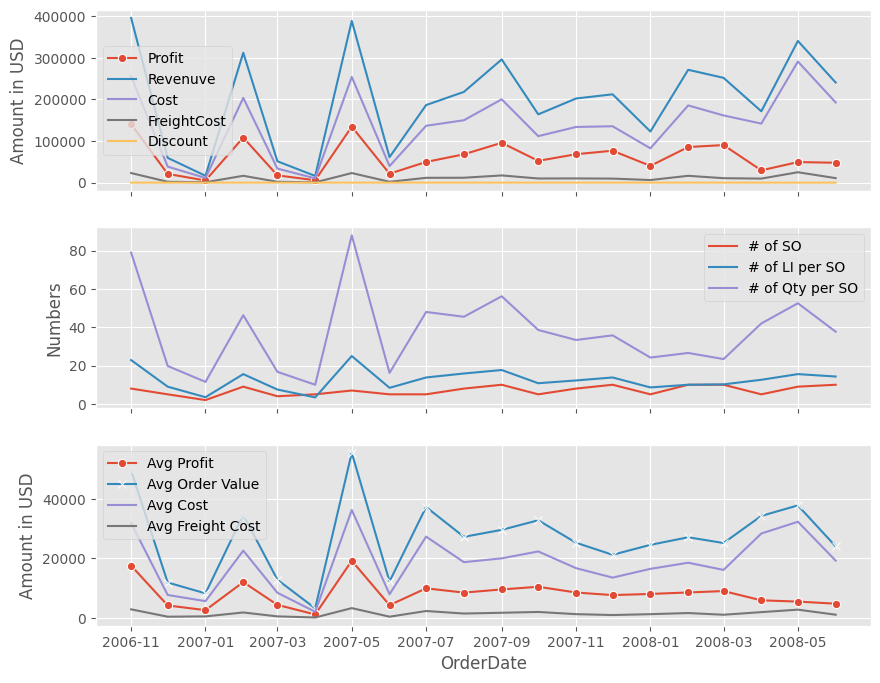

In [123]:
df_data_monthly_province_mass = df_data_monthly_province[
    df_data_monthly_province["Sales_Province"] == "Massachusetts"
]

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))
_ = sns.lineplot(
    data=df_data_monthly_province_mass,
    x="OrderDate",
    y="LineProfit",
    label="Profit",
    marker="o",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_mass,
    x="OrderDate",
    y="LineRevenue",
    label="Revenuve",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_mass,
    x="OrderDate",
    y="LineCost",
    label="Cost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_mass,
    x="OrderDate",
    y="LineFreightCost",
    label="FreightCost",
    ax=ax1,
)
_ = sns.lineplot(
    data=df_data_monthly_province_mass,
    x="OrderDate",
    y="LineDiscount",
    label="Discount",
    ax=ax1,
)
ax1.set_ylabel("Amount in USD")
_ = sns.lineplot(
    data=df_data_monthly_province_mass,
    x="OrderDate",
    y="SalesOrderNumber",
    label="# of SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_province_mass,
    x="OrderDate",
    y="LIPerSO",
    label="# of LI per SO",
    ax=ax2,
)
_ = sns.lineplot(
    data=df_data_monthly_province_mass,
    x="OrderDate",
    y="QtyPerSO",
    label="# of Qty per SO",
    ax=ax2,
)
ax2.set_ylabel("Numbers")
_ = sns.lineplot(
    data=df_data_monthly_province_mass,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit",
    marker="o",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_mass,
    x="OrderDate",
    y="AvgOrderValueSO",
    label="Avg Order Value",
    marker="x",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_mass,
    x="OrderDate",
    y="AvgCostSO",
    label="Avg Cost",
    ax=ax3,
)
_ = sns.lineplot(
    data=df_data_monthly_province_mass,
    x="OrderDate",
    y="AvgFreightCostSO",
    label="Avg Freight Cost",
    ax=ax3,
)
ax3.set_ylabel("Amount in USD")
plt.show()


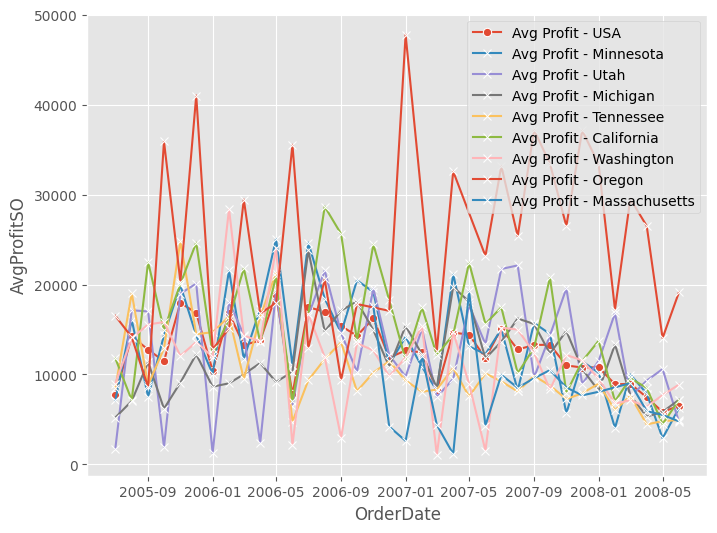

In [124]:
fig, axes = plt.subplots(figsize=(8, 6))
_ = sns.lineplot(
    data=df_data_monthly_region_usa,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit - USA",
    marker="o",
)
_ = sns.lineplot(
    data=df_data_monthly_province_minn,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit - Minnesota",
    marker="x",
)
_ = sns.lineplot(
    data=df_data_monthly_province_utah,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit - Utah",
    marker="x",
)
_ = sns.lineplot(
    data=df_data_monthly_province_mich,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit - Michigan",
    marker="x",
)
_ = sns.lineplot(
    data=df_data_monthly_province_tenn,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit - Tennessee",
    marker="x",
)
_ = sns.lineplot(
    data=df_data_monthly_province_cali,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit - California",
    marker="x",
)
_ = sns.lineplot(
    data=df_data_monthly_province_wash,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit - Washington",
    marker="x",
)
_ = sns.lineplot(
    data=df_data_monthly_province_oreg,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit - Oregon",
    marker="x",
)
_ = sns.lineplot(
    data=df_data_monthly_province_mass,
    x="OrderDate",
    y="AvgProfitSO",
    label="Avg Profit - Massachusetts",
    marker="x",
)
plt.show()


In [125]:
fig.savefig("./figures/USAProvince.png", format="png")


- Oregon province has highest impact on Average Profit per SO
- All the proviance follow more or less same tread where Average Profit per SO is deacreasing Sept 2007 onwards with highs and lows in between.

## Variation in Unit_Cost

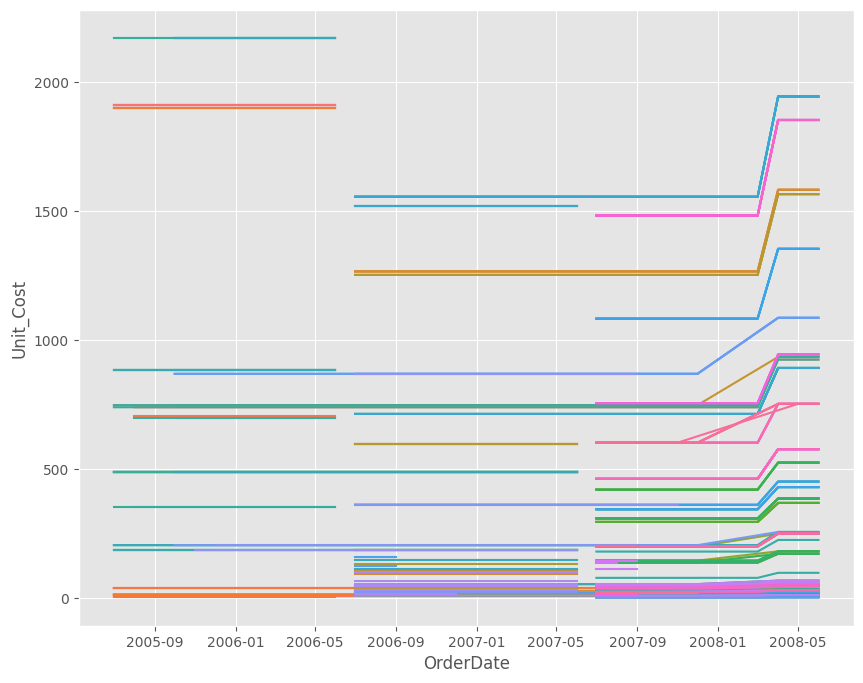

In [126]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.lineplot(
    data=df_data, x="OrderDate", y="Unit_Cost", hue="Product_Name", legend=False
)
plt.show()


In [127]:
fig.savefig("./figures/UnitCost.png", format="png")


 - The *Unit_Cost* corresponding to a product remains constants for most of the duration in the timeframe
 - A sharp increase in *Unit_Cost* happen in **March 2008** for mostly all of the products

## Variation in UnitPrice

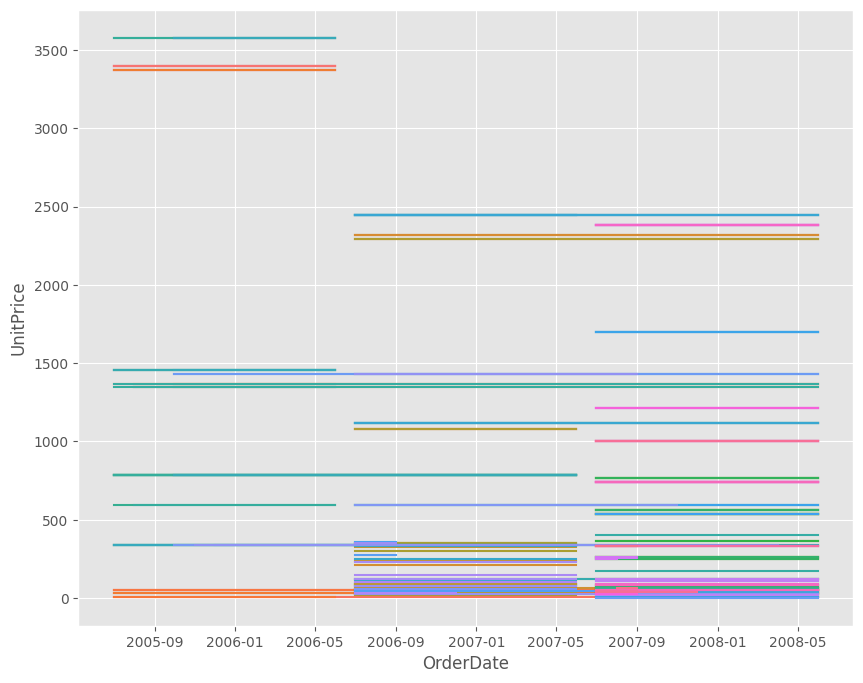

In [128]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.lineplot(
    data=df_data, x="OrderDate", y="UnitPrice", hue="Product_Name", legend=False
)
plt.show()


In [129]:
fig.savefig("./figures/UnitPrice.png", format="png")


 - The *UnitPrice* of a product remains constant over the period

## Variation in UnitPriceDiscount

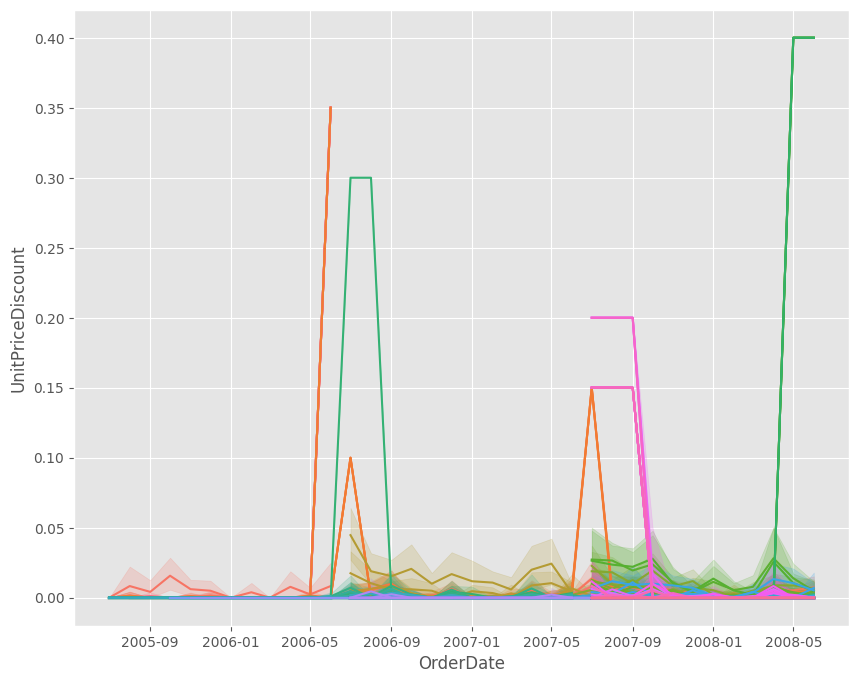

In [130]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.lineplot(
    data=df_data, x="OrderDate", y="UnitPriceDiscount", hue="Product_Name", legend=False
)
plt.show()


- Although we have ignored the *UnitPriceDiscount* as it has no to less effect on Profit, it is good to note a sudden change in discount for one of a product from 0 t0 40% in May 2008

## Variations in Final UnitCost

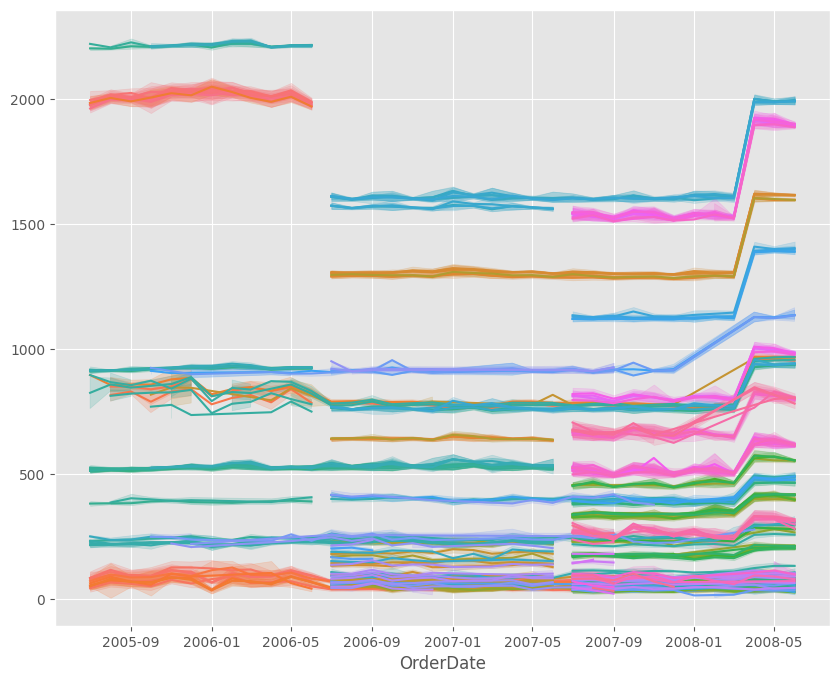

In [131]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.lineplot(
    data=df_data,
    x="OrderDate",
    y=df_data["LineCost"] / df_data["OrderQty"],
    hue="Product_Name",
    legend=False,
)
plt.show()


 - FinalUnitCost show similar trends as UnitCost
 - The FinalUnitCost increased due to adjustment of UnitCost from April 2008

## Cohert Analysis

In [132]:
df_cohort = df_data.groupby(["OrderDate", "MinOrderDate"]).agg({"LineProfit": "sum"})
df_cohort = df_cohort.sort_values(by=["MinOrderDate", "OrderDate"])
df_cohort = df_cohort.unstack(level=0)
df_cohort.head()


LineProfit                                         \
OrderDate      2005-07-01   2005-08-01   2005-09-01   2005-10-01   
MinOrderDate                                                       
2005-07-01    238512.8023          NaN          NaN  374145.6953   
2005-08-01            NaN  769647.6587          NaN          NaN   
2005-09-01            NaN          NaN  612043.9186          NaN   
2005-10-01            NaN          NaN          NaN    4605.4186   
2005-11-01            NaN          NaN          NaN          NaN   

                                                                   \
OrderDate       2005-11-01   2005-12-01   2006-01-01   2006-02-01   
MinOrderDate                                                        
2005-07-01             NaN          NaN  341201.9883          NaN   
2005-08-01    1.187694e+06          NaN          NaN  993623.5226   
2005-09-01             NaN  874684.7072          NaN          NaN   
2005-10-01             NaN          NaN    2452.4150          NaN   
2005-11-01    1.570170e+04          NaN          NaN   15097.9682   

                                        ...                            \
OrderDate      2006-03-01   2006-04-01  ...   2007-09-01   2007-10-01   
MinOrderDate                            ...                             
2005-07-01            NaN  409988.5288  ...          NaN  252198.9131   
2005-08-01            NaN          NaN  ...          NaN          NaN   
2005-09-01    684480.4859          NaN  ...  304524.6563          NaN   
2005-10-01            NaN    3553.7774  ...          NaN    2505.4457   
2005-11-01            NaN          NaN  ...          NaN          NaN   

                                                                               \
OrderDate      2007-11-01   2007-12-01   2008-01-01   2008-02-01   2008-03-01   
MinOrderDate                                                                    
2005-07-01            NaN          NaN  200585.6219          NaN          NaN   
2005-08-01    395495.3900          NaN          NaN  332565.2503          NaN   
2005-09-01            NaN  225402.0899          NaN          NaN  171486.5239   
2005-10-01            NaN          NaN    2047.1292          NaN          NaN   
2005-11-01      8564.0249          NaN          NaN    6131.1498          NaN   

                                                          
OrderDate       2008-04-01     2008-05-01     2008-06-01  
MinOrderDate                                              
2005-07-01    141746.36540            NaN            NaN  
2005-08-01             NaN  216254.753825            NaN  
2005-09-01             NaN            NaN  137879.763125  
2005-10-01       577.00615            NaN            NaN  
2005-11-01             NaN    3803.989675            NaN  

[5 rows x 36 columns]

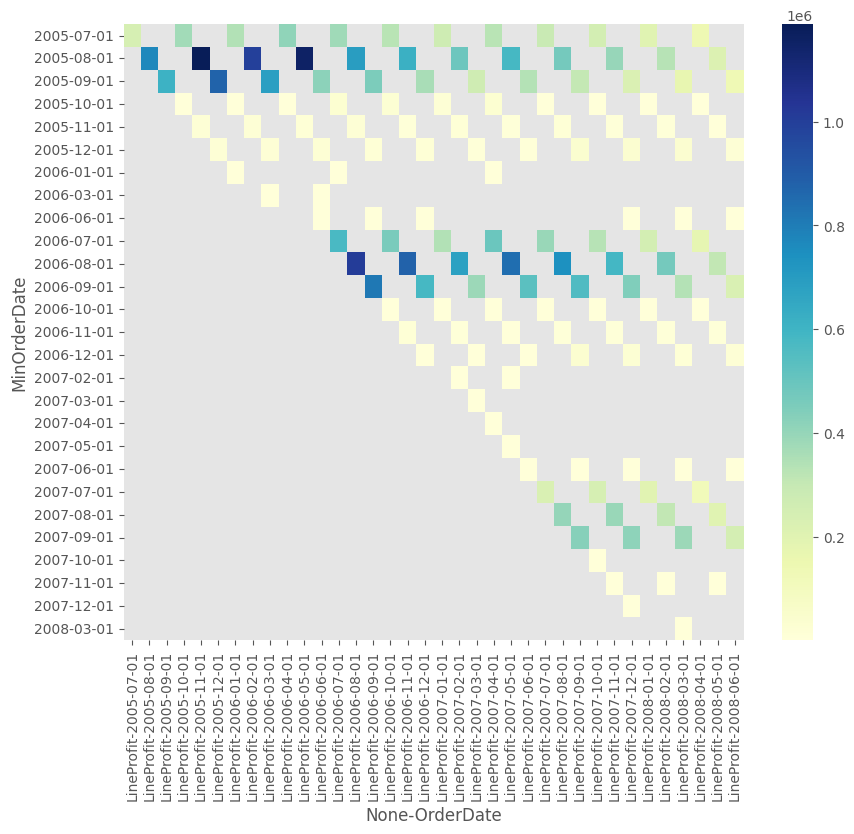

In [133]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_cohort, cmap="YlGnBu")
plt.show()


In [134]:
fig.savefig("./figures/CustomerCohort.png", format="png")
